In [1]:
# import libraries
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_processed = os.path.join('..', '..', 'data', 'processed')
df = pd.read_pickle(os.path.join(path_to_processed, 'df_1.pkl'))
df_mapped = pd.read_pickle(os.path.join(path_to_processed, 'df_2.pkl'))

For the purpose of this project, I will just focus on one specific type of property **"Household, single family units"** since they take up a portion among all the residential types of properties in the dataset. 

In [3]:
df_1 = df_mapped[df_mapped.PropertyType == 'Household, single family units'].copy()

In [4]:
df_1.head()

PIN  SalePrice ExciseTaxNbr DocumentDate    RecordingNbr  \
0   2130430120     560000      3027422   2019-12-20  20191226000848   
1   9406520630     435000      3002257   2019-07-22  20190730001339   
8   3470500040     648500      2982060   2019-04-04                   
11  0302000645     380000      2976405   2019-03-04  20190306000786   
14  0826079096     930000      2997972   2019-06-28  20190705000858   

                      PropertyType          PropertyClass BldgNbr  \
0   Household, single family units  Res-Improved property       1   
1   Household, single family units  Res-Improved property       1   
8   Household, single family units  Res-Improved property       1   
11  Household, single family units  Res-Improved property       1   
14  Household, single family units  Res-Improved property       1   

    NbrLivingUnits                       Address  ...  SewerSystem  \
0                1  27033  NE DOROTHY ST   98019  ...       PUBLIC   
1                1    22848  SE 264TH CT   98038  ...       PUBLIC   
8                1         26034   231ST PL SE    ...       PUBLIC   
11               1     30810   55TH AVE S  98001  ...      PRIVATE   
14               1    30606  NE 183RD ST   98019  ...      PRIVATE   

   StreetSurface  RestrictiveSzShape  InadequateParking  PcntUnusable  \
0          PAVED                   0                  0             0   
1          PAVED                   0                  0             0   
8          PAVED                   0                  0             0   
11         PAVED                   0           ADEQUATE             0   
14        GRAVEL                   0           ADEQUATE             0   

    LotDepthFactor  TrafficNoise  NbrBldgSites  Contamination  WaterProblems  
0                0             0             0              0              N  
1                0             0             0              0              N  
8                0             0             0              0              N  
11               0             0             5              0              N  
14               0             0             0              0              N  

[5 rows x 60 columns]

In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18320 entries, 0 to 821
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PIN                 18320 non-null  object        
 1   SalePrice           18320 non-null  int64         
 2   ExciseTaxNbr        18320 non-null  object        
 3   DocumentDate        18320 non-null  datetime64[ns]
 4   RecordingNbr        18320 non-null  object        
 5   PropertyType        18320 non-null  object        
 6   PropertyClass       18320 non-null  object        
 7   BldgNbr             18320 non-null  object        
 8   NbrLivingUnits      18320 non-null  int64         
 9   Address             18320 non-null  object        
 10  Stories             18320 non-null  float64       
 11  BldgGrade           18320 non-null  object        
 12  SqFt1stFloor        18320 non-null  int64         
 13  SqFtHalfFloor       18320 non-null  int64       

This current version of the dataset that I will be using for first round of model fitting contains 18,320 data points and 60 columns.

## Baseline Model

The goal for now is to get a baseline model up and running.

### Data Understanding

I will start with a histogram with kde of `SalePrice` to see how the distribution of our target variable looks like.

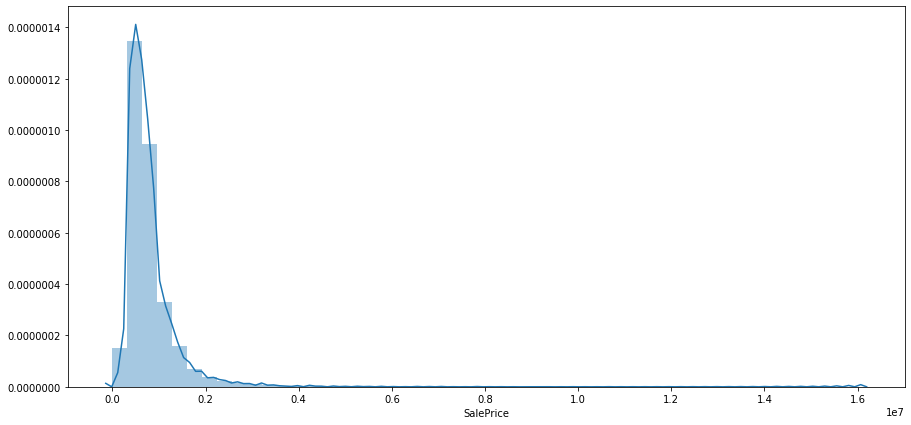

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(df_1.SalePrice);

`SalePrice` is right skewed --> will definitely need to remove outliers in `SalePrice` later on.

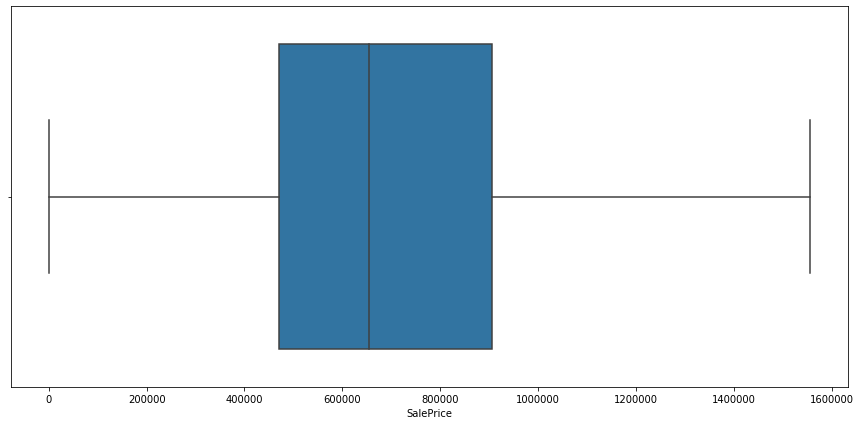

In [7]:
# boxplot with 'showfliers=False' to see how it might look like without the large valued outliers
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(df_1.SalePrice, showfliers=False);

In [8]:
df_1.describe()

SalePrice  NbrLivingUnits       Stories  SqFt1stFloor  \
count  1.832000e+04    18320.000000  18320.000000  18320.000000   
mean   7.935137e+05        1.009116      1.515366   1271.200055   
std    5.876729e+05        0.106935      0.533778    498.862584   
min    1.000000e+01        1.000000      1.000000      1.000000   
25%    4.700000e+05        1.000000      1.000000    960.000000   
50%    6.550000e+05        1.000000      1.500000   1210.000000   
75%    9.050000e+05        1.000000      2.000000   1490.000000   
max    1.605000e+07        3.000000      3.500000   6070.000000   

       SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  SqFtUnfinFull  \
count   18320.000000  18320.000000    18320.000000   18320.000000   
mean       45.382369    513.277784       13.016321       0.624454   
std       166.818538    660.336520       88.501267      21.941439   
min         0.000000      0.000000        0.000000       0.000000   
25%         0.000000      0.000000        0.000000       0.000000   
50%         0.000000      0.000000        0.000000       0.000000   
75%         0.000000   1020.000000        0.000000       0.000000   
max      2160.000000   5110.000000     1800.000000    1350.000000   

       SqFtUnfinHalf  SqFtTotLiving  ...  BathFullCount       YrBuilt  \
count   18320.000000   18320.000000  ...   18320.000000  18320.000000   
mean        0.509389    2145.032096  ...       1.578493   1974.594814   
std        16.267978     967.268953  ...       0.699876     30.430402   
min         0.000000       2.000000  ...       0.000000   1900.000000   
25%         0.000000    1450.000000  ...       1.000000   1954.000000   
50%         0.000000    1970.000000  ...       1.000000   1978.000000   
75%         0.000000    2630.000000  ...       2.000000   2001.000000   
max       920.000000   10910.000000  ...       7.000000   2020.000000   

        YrRenovated  PcntComplete  PcntNetCondition     AddnlCost  \
count  18320.000000  18320.000000      18320.000000  18320.000000   
mean      98.141921      0.278275          0.001365    713.285862   
std      432.055811      4.784221          0.107314   2564.182713   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.000000      0.000000          0.000000      0.000000   
50%        0.000000      0.000000          0.000000      0.000000   
75%        0.000000      0.000000          0.000000      0.000000   
max     2020.000000    100.000000         10.000000  60000.000000   

             SqFtLot  PcntUnusable  LotDepthFactor  NbrBldgSites  
count   18320.000000  18320.000000    18320.000000  18320.000000  
mean    15254.035153      0.003275        0.053930      0.006004  
std     38562.405672      0.316219        2.119946      0.107409  
min       375.000000      0.000000        0.000000      0.000000  
25%      5040.000000      0.000000        0.000000      0.000000  
50%      7593.000000      0.000000        0.000000      0.000000  
75%     10768.000000      0.000000        0.000000      0.000000  
max    897336.000000     34.000000      105.000000      5.000000  

[8 rows x 31 columns]

In [9]:
corr1 = df_1.corr()
corr1.SalePrice.sort_values(ascending=False)

SalePrice             1.000000
SqFtTotLiving         0.621684
SqFt1stFloor          0.401388
SqFt2ndFloor          0.382351
BathFullCount         0.320876
SqFtFinBasement       0.288444
SqFtOpenPorch         0.274658
Bedrooms              0.273552
SqFtTotBasement       0.268104
Stories               0.250264
Bath3qtrCount         0.233517
BathHalfCount         0.221975
SqFtDeck              0.206602
SqFtGarageAttached    0.171604
YrRenovated           0.116915
AddnlCost             0.102764
YrBuilt               0.088981
SqFtUpperFloor        0.077235
BrickStone            0.077179
SqFtLot               0.074171
SqFtHalfFloor         0.066321
LotDepthFactor        0.055977
SqFtGarageBasement    0.051505
PcntComplete          0.049037
NbrBldgSites          0.010657
NbrLivingUnits        0.010211
SqFtEnclosedPorch     0.008784
PcntUnusable          0.007799
SqFtUnfinFull         0.004044
SqFtUnfinHalf         0.002736
PcntNetCondition     -0.006144
Name: SalePrice, dtype: float64

In [10]:
def corr_heatmap(corr):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    fig1, ax1 = plt.subplots(figsize=(20,15))
    sns.heatmap(corr, mask=mask, ax=ax1, cmap='viridis');

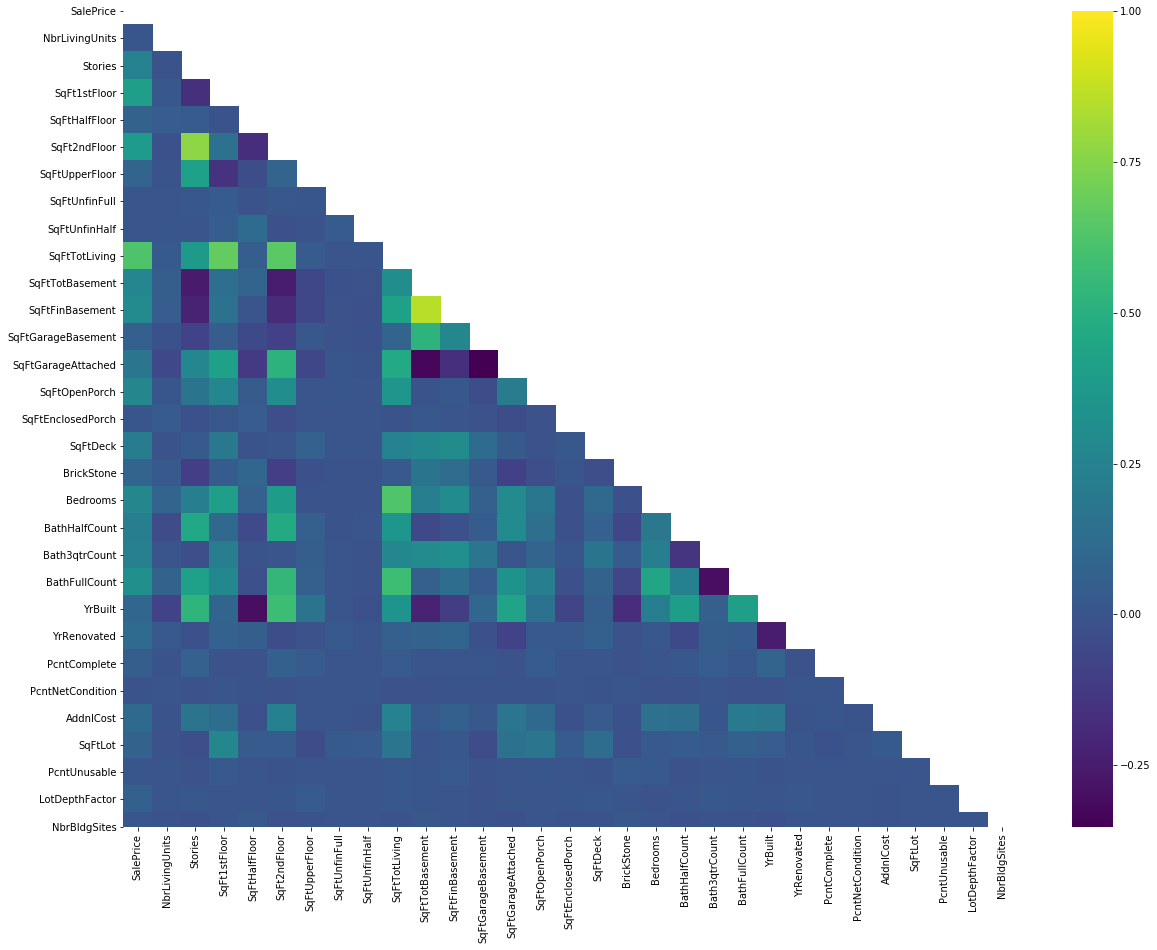

In [11]:
corr_heatmap(corr1)

Looking at the heatmap above, there is multicollinearity between different numeric features. I will need to engineer these features to either remove some of them, or somehow combine them into one. 

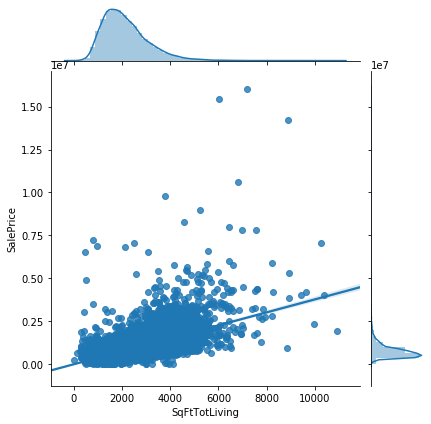

In [12]:
sns.jointplot(data=df_1, x='SqFtTotLiving', y='SalePrice', kind="reg");

- As of now, `SqFtTotLiving` seems to have the highest positive correlation with `SalePrice` at 0.621684, which is not bad. 
- A quick visual check of Linearity between `SqFtTotLiving` and `SalePrice` using seaborn's `.jointplot()` shows that:
    - both are normally distributed
    - both are heavily right skewed (meaning there are minorities of very large values)
    - the relationship between the two are pretty linear for the most part, with some outliers seems to be pulling the line upwards a little bit. 
    
--> definitely need to apply log and/or other types of transformation on these variables later along with removing some of the outliers to reduce skewness. 

But first, I will proceed to do the first simple model with just 1 predictor `SqFtTotLiving` without any cleaning or transformations to see how our results look.

### First Simple Model

In [13]:
sm_1_df = df_1[['SalePrice', 'SqFtTotLiving']].copy()

In [14]:
sm_1_df.isna().sum()

SalePrice        0
SqFtTotLiving    0
dtype: int64

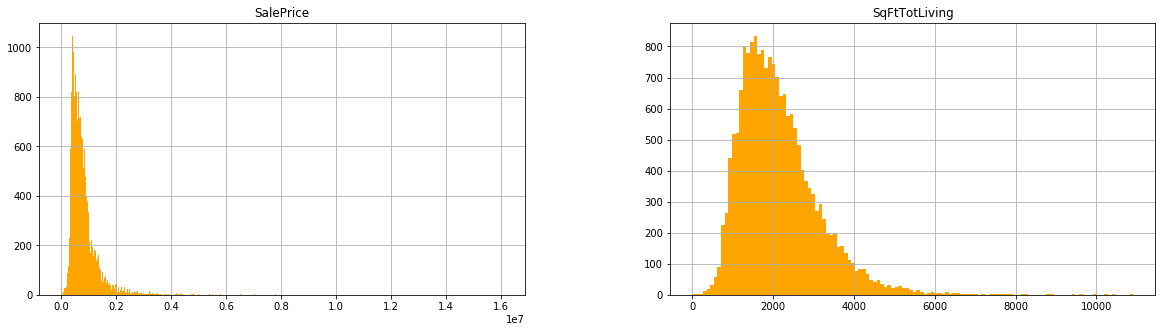

In [15]:
sm_1_df.hist(figsize=(20,5), color='orange', bins='auto');

In [16]:
def get_predictors(df, outcome):
    """
    Return a list of predictors based on the specified outcome column of a dataset
    """
    return [c for c in df.columns if c != outcome]

In [17]:
# a function that create the formula based on target and predictors passed in 
def create_formula(outcome, predictors):
    """
    Return a string formula for statsmodels OLS
    """
    f = outcome + ' ~ ' + ' + '.join(predictors)
    return f

In [18]:
outcome = 'SalePrice'
predictors = get_predictors(sm_1_df, outcome)
formula = create_formula(outcome, predictors)
sm_1 = ols(formula=formula, data=sm_1_df).fit()
sm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.154e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:33:59   Log-Likelihood:            -2.6488e+05
No. Observations:               18320   AIC:                         5.298e+05
Df Residuals:                   18318   BIC:                         5.298e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.669e+04   8273.441     -2.017      0.044   -3.29e+04    -468.867
SqFtTotLiving   377.7096      3.516    107.423      0.000     370.818     384.601
==============================================================================
Omnibus:                    23794.512   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13050553.171
Skew:                           6.856   Prob(JB):                         0.00
Kurtosis:                     133.034   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Evaluation

Our first simple model is currently able to explain about 38.6% the variance of `SalePrice`, which is not a bad start, given that this model only has 1 feature. p-value for the Intercept is 0.044, which is quite close to our significance level of 0.05, but technically still considered "statistically significant." Coefficient for `SqFtTotLiving` has a p-value of 0.000 (< 0.05) so it is also statistically significant.

- Our first simple model is currently predicting a sale price of USD -16,690 when total living space is 0 sqft, which does NOT NOT make sense...
- And with an increase of 1 sqft in total living space, the sale price is expected to increase by USD 377.7096, which seems to be on the higher side of average price per sqft in the US (compared to various sources on the internet).

As I will most likely have to repeat the checking of the Linear Regression assumptions a number of times moving forwards, I am creating a function that combines the 3 tests: 
- Rainbow for Linearity 
- Jarque-Bera for Normality 
- Breusch-Pagan test as well as Residuals Plot for Homoskedasticity

In [19]:
# get vif (variance inflation factor) to check for Multicollinearity
def get_vif(df, predictors):
    """
    Return a variance inflation factor dataframe for all the 
    predictors used in a model
    """
    rows = df[predictors].values
    vif_df = pd.DataFrame()
    vif_df["feature"] = predictors
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(predictors))]
    return vif_df

In [20]:
def check_lr_assumptions(model, df, outcome, predictors):  
    print('\t\t\t\t\tStatistic \tP-value')
    # Linearity (using Rainbow Test)
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    print(f'(Linearity) Rainbow Test \t\t{round(rainbow_statistic,3)} \t\t{round(rainbow_p_value,3)}')
    
    # Normality (using Jarque-Bera)
    residuals = model.resid
    jb = jarque_bera(residuals, axis=0)
    jb_statistic, jb_p_value = jb[:2]
    print(f'(Normality) Jarque-Bera Test \t\t{round(jb_statistic,3)} \t{round(jb_p_value,3)}')
    print()
    # Homoskedasticity (using Breusch-Pagan test)
    y = df[outcome]
    y_hat = model.predict()
    print('\t\t\t\t\tLagrange Multiplier p-value \tF-statistic p-value')
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, df[predictors])
    print(f'(Homoskedasticity) Breusch-Pagan test \t{round(lm_p_value,3)} \t\t\t\t{round(f_p_value,3)}')
    
    # print out vif dataframe if there are more than 1 predictors being used
    if len(predictors) >= 2:
        vif_df = get_vif(df, predictors)
        print()
        print('Independence:')
        print(vif_df)
    
    # Plot residuals to check for homoskedasticity
    fig2, ax2 = plt.subplots(figsize=(10,7))
    ax2.set(xlabel='Predicted Sale Price',
            ylabel='Residuals (Predicted - Actual Sale Price)')
    ax2.hlines(y=0, xmin=y_hat.min(), xmax=y_hat.max(), color='red', lw=0.5)
    ax2.scatter(x=y_hat, y=y_hat-y, color='blue', alpha=0.2);

					Statistic 	P-value
(Linearity) Rainbow Test 		0.873 		1.0
(Normality) Jarque-Bera Test 		13050553.171 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


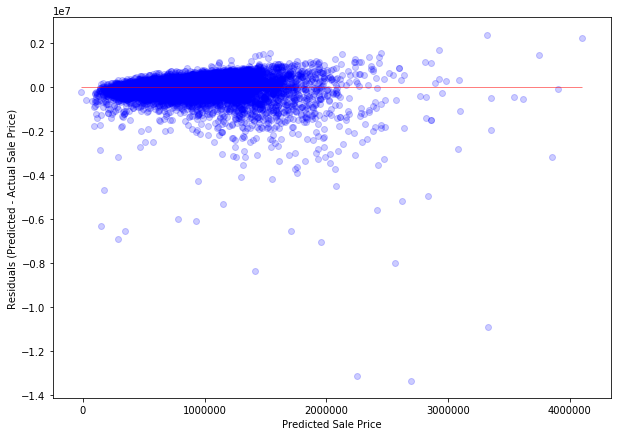

In [21]:
check_lr_assumptions(sm_1, sm_1_df, outcome, predictors)

So far, our model has met the Linearity Assumption (since the Rainbow test p-value is 1.0, which is greater than our significance level of 0.05). Yet it's violating Normality as well as Homoskedasticity Assumptions (the p-values for both Jarque-Bera and Breusch-Pagan tests are smaller than 0.05).

This model is using only 1 feature, therefore I don't need to check for Multicollinearity yet. 

Since model fitting is going to be an iterative process, I will create a dataframe called `model_results` which keeps track of all the different models I've trained and some of their statistical results for easy performance comparison later on. 

In [22]:
# initiate model_results dataframe
model_results = pd.DataFrame({'Model': [], 'Formula': [], 'R-Squared': [], 
                              'Rainbow statistic': [], 'Rainbow p-value': [], 'Linearity Assumption': [],
                              'Jarque-Bera statistic': [], 'Jarque-Bera p-value': [], 'Normality Assumption': [],
                              'Lagrange Multiplier p-value': [], 'F-statistic p-value': [], 'Homoskedasticity Assumption': [],
                              'Multicollinearity': [], 'Independence Assumption': [],
                              'Note': []})

In [23]:
model_results

Empty DataFrame
Columns: [Model, Formula, R-Squared, Rainbow statistic, Rainbow p-value, Linearity Assumption, Jarque-Bera statistic, Jarque-Bera p-value, Normality Assumption, Lagrange Multiplier p-value, F-statistic p-value, Homoskedasticity Assumption, Multicollinearity, Independence Assumption, Note]
Index: []

In [24]:
def append_results(model_name, formula, model, df, outcome, predictors, alpha=0.05, note=None):
    r2 = model.rsquared
    
    # rainbow (for linearity)
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    linear_eval = 'Violated' if rainbow_p_value < alpha else 'Satisfied'
    
    # jarque-bera (for normality)
    residuals = model.resid
    jb = jarque_bera(residuals, axis=0)
    jb_statistic, jb_p_value = jb[:2]
    normal_eval = 'Violated' if jb_p_value < alpha else 'Satisfied'
    
    # breusch-pagan (for homoskedasticity)
    y = df[outcome]
    yhat = model.predict()
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-yhat, df[predictors])
    homoskedasticity_eval = 'Violated' if f_p_value < alpha else 'Satisfied'
    
    # check for multicollinearity
    # if there's only 1 predictor, Independence Assumption is not applicable
    if len(predictors) == 1:
        multicollinearity = 'N/A'
        independence_eval = 'N/A'
    # if there're more than 1 predictors
    else:
        vif_df = get_vif(df, predictors)
        # select all the predictors with a VIF values greater or equal to 5
        # ("rule of thumb" for VIF is 5 is too high)
        multicollinearity = ', '.join(vif_df[vif_df.VIF >= 5].feature.values)
        independence_eval = 'Violated' if multicollinearity != '' else 'Satisfied'
    
    # append results to dataframe
    model_results.loc[len(model_results)] = [model_name, formula, r2, 
                                             rainbow_statistic, rainbow_p_value, linear_eval,
                                             jb_statistic, jb_p_value, normal_eval, 
                                             lm_p_value, f_p_value, homoskedasticity_eval,
                                             multicollinearity, independence_eval,
                                             note]
    return model_results

In [25]:
# Append the results for `sm_1` to our result dataframe
append_results('sm_1', formula, sm_1, sm_1_df, outcome, predictors, note='with outliers, no transform')

Model                    Formula  R-Squared  Rainbow statistic  \
0  sm_1  SalePrice ~ SqFtTotLiving   0.386491           0.872905   

   Rainbow p-value Linearity Assumption  Jarque-Bera statistic  \
0              1.0            Satisfied           1.305055e+07   

   Jarque-Bera p-value Normality Assumption  Lagrange Multiplier p-value  \
0                  0.0             Violated                          NaN   

   F-statistic p-value Homoskedasticity Assumption Multicollinearity  \
0         3.931011e-82                    Violated               N/A   

  Independence Assumption                         Note  
0                     N/A  with outliers, no transform

## Model 2

### Data Transformation

#### Log Transformation

In [26]:
# Create a function for log transformation that also prefixes 'log_' to column names
# (so that it'll be easier to identify what's been done on each variable looking at the plots afterwards)
def log_transform(cols, dt):
    output = dt.copy()
    for c in dt.columns:
        if c in cols:
            output[f'log_{c}'] = np.log(dt[c])
            output.drop(c, axis=1, inplace=True)
    return output

Since `SqFtTotLiving` and `SalePrice` are both right skewed right now, I will try to apply `log_transform()` on both of them to see if they'd become more symmetrical:

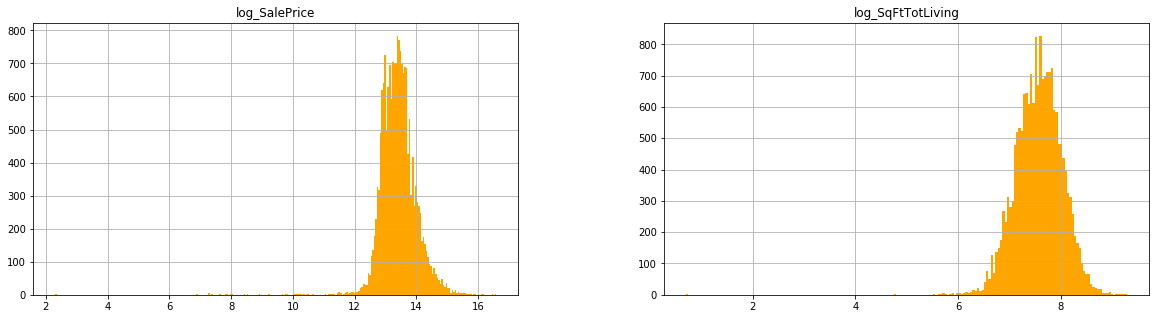

In [27]:
sm_1_log_df = log_transform(sm_1_df.columns, sm_1_df)
sm_1_log_df.hist(figsize=(20,5), color='orange', bins='auto');

`log_SalePrice` looks slightly better, but `log_SqFtTotLiving` doesn't. Also, they're now both skewed left instead of right --> probably need to remove outliers before tranformation.

#### Removing Outliers Using z-score

In [27]:
# Create a function that removes outliers using z-score
def remove_outliers_z(dt, col, threshold=3):
    """
    Remove outliers of a dataframe 'dt' using z-score for specified column 'col'
    By default, z-score thresholds are +/- 3 for a normal distribution 
    """
    z_scores = stats.zscore(dt[col])
    abs_z_scores = np.abs(z_scores)
    output = dt[abs_z_scores < threshold]
    return output

In [28]:
sm_2_df = remove_outliers_z(sm_1_df, 'SalePrice')

In [29]:
sm_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18320 entries, 0 to 821
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SalePrice      18320 non-null  int64
 1   SqFtTotLiving  18320 non-null  int64
dtypes: int64(2)
memory usage: 429.4 KB


In [30]:
sm_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18015 entries, 0 to 821
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SalePrice      18015 non-null  int64
 1   SqFtTotLiving  18015 non-null  int64
dtypes: int64(2)
memory usage: 422.2 KB


So 305 data points have been idenfitied as outliers using z-score method and removed going from `sm_1_df` to `sm_2_df`.

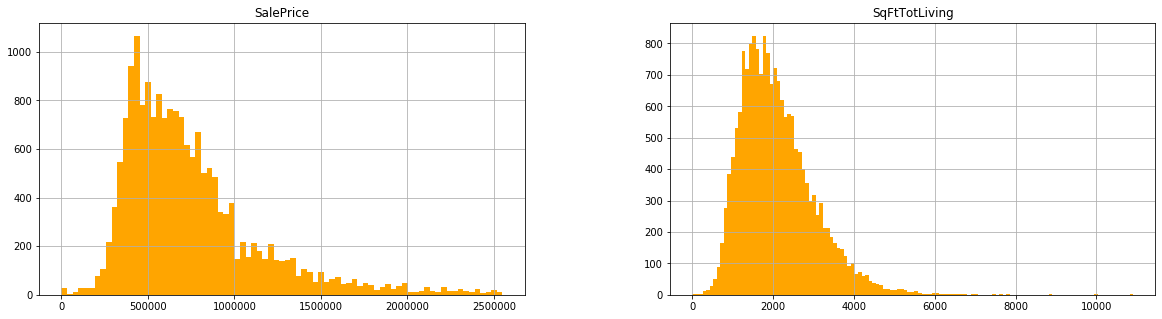

In [31]:
sm_2_df.hist(figsize=(20,5), color='orange', bins='auto');

This doesn't look bad at all! 

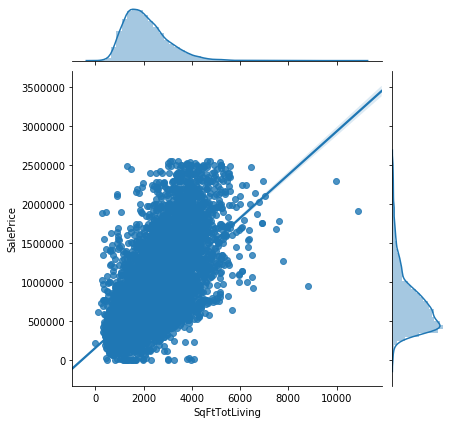

In [32]:
sns.jointplot(data=sm_2_df, x='SqFtTotLiving', y='SalePrice', kind="reg");

This definitely looks better. Let's see if log transformation is going to improve this a little more.

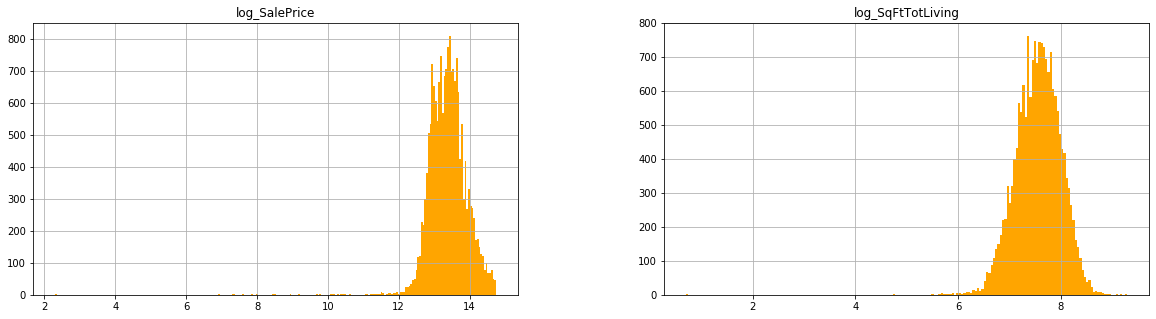

In [33]:
sm_2_log_df = log_transform(sm_2_df.columns, sm_2_df)
sm_2_log_df.hist(figsize=(20,5), color='orange', bins='auto');

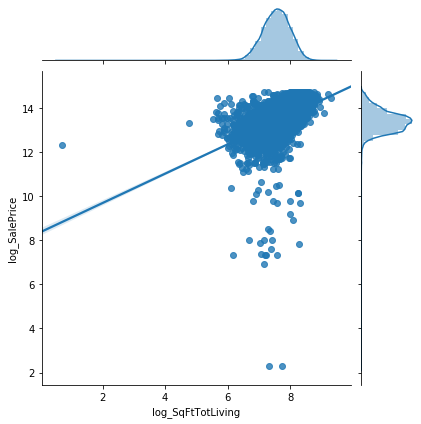

In [34]:
sns.jointplot(data=sm_2_log_df, x='log_SqFtTotLiving', y='log_SalePrice', kind="reg");

Honestly speaking, the distribution of these 2 variables and their relationship AFTER outliers removal with z-score and BEFORE log transformation look better. But let's fit 2 models on both `sm_2_df` and `sm_2_log_df` to compare the results.

In [35]:
# `sm_2_df`
outcome = 'SalePrice'
predictors = get_predictors(sm_2_df, outcome)
formula = create_formula(outcome, predictors)
sm_2 = ols(formula=formula, data=sm_2_df).fit()
sm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                 1.201e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:41:34   Log-Likelihood:            -2.5301e+05
No. Observations:               18015   AIC:                         5.060e+05
Df Residuals:                   18013   BIC:                         5.060e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.616e+05   5776.194     27.977      0.000     1.5e+05    1.73e+05
SqFtTotLiving   276.8171      2.526    109.569      0.000     271.865     281.769
==============================================================================
Omnibus:                     3422.527   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8752.700
Skew:                           1.044   Prob(JB):                         0.00
Kurtosis:                       5.703   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.028 		0.095
(Normality) Jarque-Bera Test 		8752.7 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


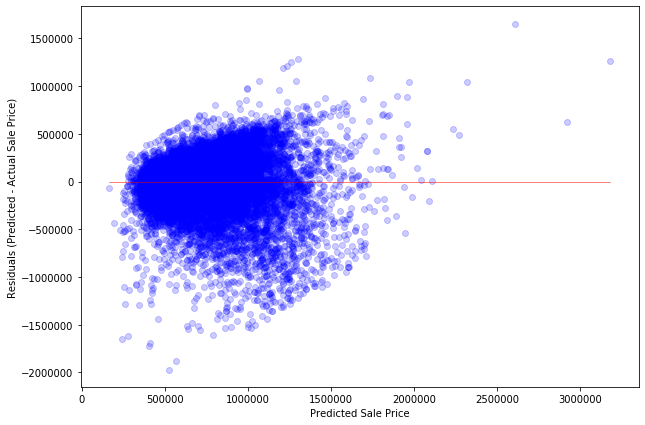

In [36]:
check_lr_assumptions(sm_2, sm_2_df, outcome, predictors)

In [37]:
append_results('sm_2', formula, sm_2, sm_2_df, outcome, predictors, note='remove SalePrice outliers with z-score')

Model                    Formula  R-Squared  Rainbow statistic  \
0  sm_1  SalePrice ~ SqFtTotLiving   0.386491           0.872905   
1  sm_2  SalePrice ~ SqFtTotLiving   0.399934           1.027984   

   Rainbow p-value Linearity Assumption  Jarque-Bera statistic  \
0         1.000000            Satisfied           1.305055e+07   
1         0.095171            Satisfied           8.752700e+03   

   Jarque-Bera p-value Normality Assumption  Lagrange Multiplier p-value  \
0                  0.0             Violated                          NaN   
1                  0.0             Violated                          NaN   

   F-statistic p-value Homoskedasticity Assumption Multicollinearity  \
0         3.931011e-82                    Violated               N/A   
1         0.000000e+00                    Violated               N/A   

  Independence Assumption                                    Note  
0                     N/A             with outliers, no transform  
1                     N/A  remove SalePrice outliers with z-score

In [38]:
# `sm_2_log_df`
outcome = 'log_SalePrice'
predictors = get_predictors(sm_2_log_df, outcome)
formula = create_formula(outcome, predictors)
sm_2_log = ols(formula=formula, data=sm_2_log_df).fit()
sm_2_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_SalePrice   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     7424.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:41:59   Log-Likelihood:                -11005.
No. Observations:               18015   AIC:                         2.201e+04
Df Residuals:                   18013   BIC:                         2.203e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.3679      0.058    143.216      0.000       8.253       8.482
log_SqFtTotLiving     0.6647      0.008     86.164      0.000       0.650       0.680
==============================================================================
Omnibus:                    15872.450   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3094761.866
Skew:                          -3.557   Prob(JB):                         0.00
Kurtosis:                      66.815   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.353 		0.0
(Normality) Jarque-Bera Test 		3094761.866 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


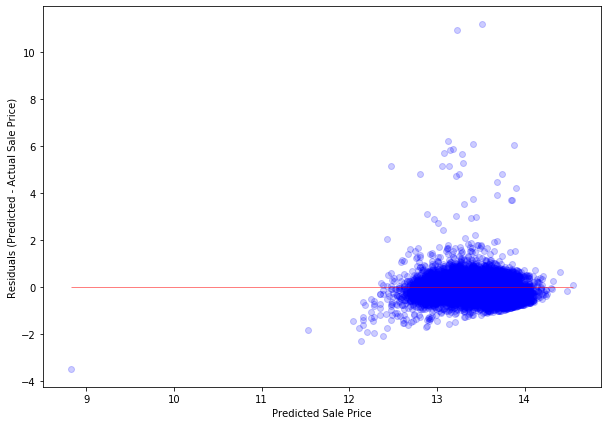

In [39]:
check_lr_assumptions(sm_2_log, sm_2_log_df, outcome, predictors)

In [40]:
append_results('sm_2_log', formula, sm_2_log, sm_2_log_df, outcome, predictors, 
               note='remove SalePrice outliers w/ z-scores then log transformed')

Model                            Formula  R-Squared  Rainbow statistic  \
0      sm_1          SalePrice ~ SqFtTotLiving   0.386491           0.872905   
1      sm_2          SalePrice ~ SqFtTotLiving   0.399934           1.027984   
2  sm_2_log  log_SalePrice ~ log_SqFtTotLiving   0.291863           1.352501   

   Rainbow p-value Linearity Assumption  Jarque-Bera statistic  \
0     1.000000e+00            Satisfied           1.305055e+07   
1     9.517113e-02            Satisfied           8.752700e+03   
2     1.084791e-46             Violated           3.094762e+06   

   Jarque-Bera p-value Normality Assumption  Lagrange Multiplier p-value  \
0                  0.0             Violated                          NaN   
1                  0.0             Violated                          NaN   
2                  0.0             Violated                          NaN   

   F-statistic p-value Homoskedasticity Assumption Multicollinearity  \
0         3.931011e-82                    Violated               N/A   
1         0.000000e+00                    Violated               N/A   
2         1.163439e-59                    Violated               N/A   

  Independence Assumption                                               Note  
0                     N/A                        with outliers, no transform  
1                     N/A             remove SalePrice outliers with z-score  
2                     N/A  remove SalePrice outliers w/ z-scores then log...

In [41]:
model_results.sort_values(by='R-Squared', ascending=False)

Model                            Formula  R-Squared  Rainbow statistic  \
1      sm_2          SalePrice ~ SqFtTotLiving   0.399934           1.027984   
0      sm_1          SalePrice ~ SqFtTotLiving   0.386491           0.872905   
2  sm_2_log  log_SalePrice ~ log_SqFtTotLiving   0.291863           1.352501   

   Rainbow p-value Linearity Assumption  Jarque-Bera statistic  \
1     9.517113e-02            Satisfied           8.752700e+03   
0     1.000000e+00            Satisfied           1.305055e+07   
2     1.084791e-46             Violated           3.094762e+06   

   Jarque-Bera p-value Normality Assumption  Lagrange Multiplier p-value  \
1                  0.0             Violated                          NaN   
0                  0.0             Violated                          NaN   
2                  0.0             Violated                          NaN   

   F-statistic p-value Homoskedasticity Assumption Multicollinearity  \
1         0.000000e+00                    Violated               N/A   
0         3.931011e-82                    Violated               N/A   
2         1.163439e-59                    Violated               N/A   

  Independence Assumption                                               Note  
1                     N/A             remove SalePrice outliers with z-score  
0                     N/A                        with outliers, no transform  
2                     N/A  remove SalePrice outliers w/ z-scores then log...

Using log transformation didn't seem to help reduce skewness for `SqFtTotLiving` and `SalePrice`, which makes me curious whether getting the square root, or inversing would help.

### Squareroot Transformation

In [42]:
def sq_rt(cols, dt):
    output = dt.copy()
    for c in dt.columns:  
        if c in cols:
            output.drop(c, axis=1, inplace=True)
            output[f'sqrt_{c}'] = (dt[c])**.5
    return output

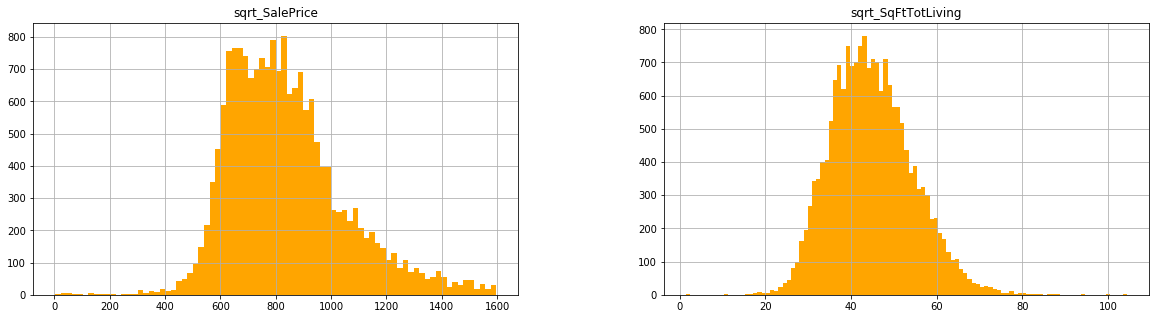

In [43]:
# Applying sq_rt() on `sm_2_df` (which has the outliers removed using z-score)
sm_2_sqrt_df = sq_rt(sm_2_df.columns, sm_2_df)
sm_2_sqrt_df.hist(figsize=(20,5), color='orange', bins='auto');

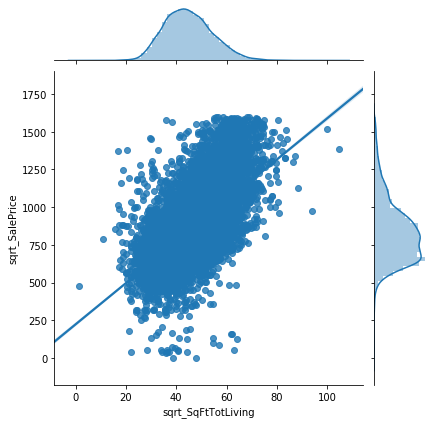

In [44]:
sns.jointplot(data=sm_2_sqrt_df, x='sqrt_SqFtTotLiving', y='sqrt_SalePrice', kind="reg");

The distributions for both is definitely looking more symmetrical here, and joint plot looks linear. Let's try to fit a model to see how it goes.

In [45]:
# `sm_2_sqrt_df`
outcome = 'sqrt_SalePrice'
predictors = get_predictors(sm_2_sqrt_df, outcome)
formula = create_formula(outcome, predictors)
sm_2_sqrt = ols(formula=formula, data=sm_2_sqrt_df).fit()
sm_2_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_SalePrice   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.100e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:48:02   Log-Likelihood:            -1.1762e+05
No. Observations:               18015   AIC:                         2.352e+05
Df Residuals:                   18013   BIC:                         2.352e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            223.5235      5.971     37.434      0.000     211.819     235.228
sqrt_SqFtTotLiving    13.6592      0.130    104.903      0.000      13.404      13.914
==============================================================================
Omnibus:                      841.580   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1509.920
Skew:                           0.372   Prob(JB):                         0.00
Kurtosis:                       4.207   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.053 		0.007
(Normality) Jarque-Bera Test 		1509.92 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


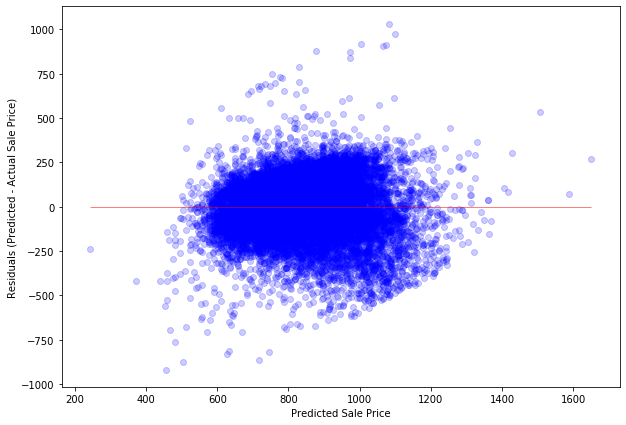

In [46]:
check_lr_assumptions(sm_2_sqrt, sm_2_sqrt_df, outcome, predictors)

In [47]:
append_results('sm_2_sqrt', formula, sm_2_sqrt, sm_2_sqrt_df, outcome, predictors, 
               note='remove SalePrice outliers w/ z-score & sqrt transformed')

Model                              Formula  R-Squared  \
0       sm_1            SalePrice ~ SqFtTotLiving   0.386491   
1       sm_2            SalePrice ~ SqFtTotLiving   0.399934   
2   sm_2_log    log_SalePrice ~ log_SqFtTotLiving   0.291863   
3  sm_2_sqrt  sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07                  0.0             Violated   
1           8.752700e+03                  0.0             Violated   
2           3.094762e+06                  0.0             Violated   
3           1.509920e+03                  0.0             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3  remove SalePrice outliers w/ z-score & sqrt tr...

Model `sm_2_sqrt` has lower R-Squared value than `sm_2`, and it also violates all 3 assumptions (Linearity, Normality, and Homoskedasticity).

Looking at the distribution plot for `SqFtTotLiving` after getting the square root, it seems like it does benefit from this transformation. Maybe applying it on just `SqFtTotLiving` instead of both variables would yield better result.

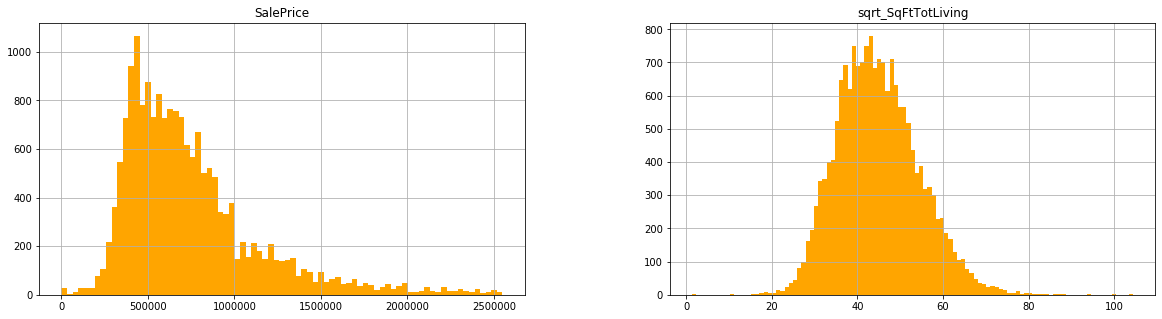

In [48]:
# Applying sq_rt() on just 'SqFtTotLiving'
sm_2_sqrt_2_df = sq_rt('SqFtTotLiving', sm_2_df)
sm_2_sqrt_2_df.hist(figsize=(20,5), color='orange', bins='auto');

In [49]:
# `sm_2_sqrt_2_df`
outcome = 'SalePrice'
predictors = get_predictors(sm_2_sqrt_2_df, outcome)
formula = create_formula(outcome, predictors)
sm_2_sqrt_2 = ols(formula=formula, data=sm_2_sqrt_2_df).fit()
sm_2_sqrt_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:51:24   Log-Likelihood:            -2.5336e+05
No. Observations:               18015   AIC:                         5.067e+05
Df Residuals:                   18013   BIC:                         5.067e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3.953e+05   1.12e+04    -35.346      0.000   -4.17e+05   -3.73e+05
sqrt_SqFtTotLiving  2.539e+04    243.884    104.093      0.000    2.49e+04    2.59e+04
==============================================================================
Omnibus:                     3596.101   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8842.146
Skew:                           1.108   Prob(JB):                         0.00
Kurtosis:                       5.621   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.034 		0.057
(Normality) Jarque-Bera Test 		8842.146 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


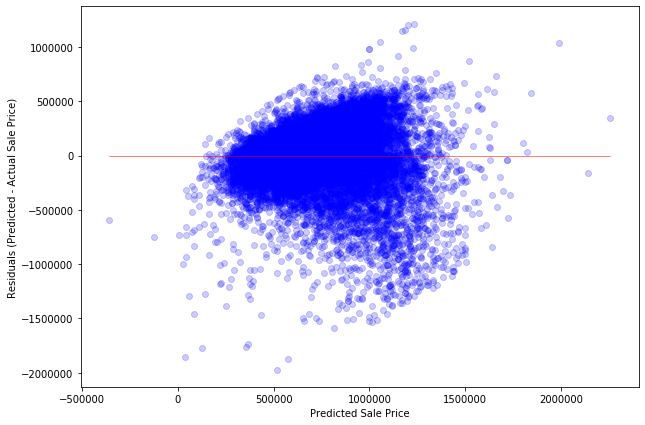

In [50]:
check_lr_assumptions(sm_2_sqrt_2, sm_2_sqrt_2_df, outcome, predictors)

In [51]:
append_results('sm_2_sqrt_2', formula, sm_2_sqrt_2, sm_2_sqrt_2_df, outcome, predictors, 
               note='remove SalePrice outliers w/ z-score & sqrt on SqFtTotLiving')

Model                              Formula  R-Squared  \
0         sm_1            SalePrice ~ SqFtTotLiving   0.386491   
1         sm_2            SalePrice ~ SqFtTotLiving   0.399934   
2     sm_2_log    log_SalePrice ~ log_SqFtTotLiving   0.291863   
3    sm_2_sqrt  sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4  sm_2_sqrt_2       SalePrice ~ sqrt_SqFtTotLiving   0.375599   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07                  0.0             Violated   
1           8.752700e+03                  0.0             Violated   
2           3.094762e+06                  0.0             Violated   
3           1.509920e+03                  0.0             Violated   
4           8.842146e+03                  0.0             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...

So far I haven't had much luck with any transformations on `SalePrice` or `SqFtTotLiving`, although the result for getting the squareroot of `SqFtTotLiving` only are not too horrible, it's still not performing as well as the Baseline model (`sm_1`). 

Next I want to try removing outliers using IQR to see how that'd look.

#### Removing Outliers Using IQR

In [52]:
def remove_outliers_iqr(dt, col):
    """
    Remove outliers of a dataframe 'dt' based on IQR specified column 'col'
    Input for method argument is either 'iqr' or 'z-score'
    
    """
    q1 = dt[col].quantile(0.25)
    q3 = dt[col].quantile(0.75)
    iqr = q3 - q1
    output = dt[(dt[col] > q1 - 1.5 * iqr) & (dt[col] < q3 + 1.5 * iqr)]
    return output

In [53]:
sm_3_df = remove_outliers_iqr(sm_1_df, 'SalePrice')
sm_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17130 entries, 0 to 821
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SalePrice      17130 non-null  int64
 1   SqFtTotLiving  17130 non-null  int64
dtypes: int64(2)
memory usage: 401.5 KB


In [54]:
sm_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18320 entries, 0 to 821
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SalePrice      18320 non-null  int64
 1   SqFtTotLiving  18320 non-null  int64
dtypes: int64(2)
memory usage: 429.4 KB


So far, the IQR method has removed more outliers in our dataset (1190) compared to the z-score method (305).

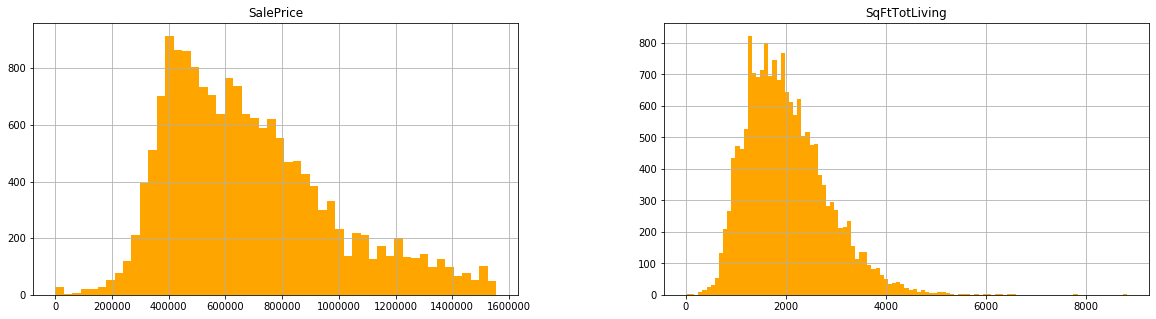

In [55]:
sm_3_df.hist(figsize=(20,5), color='orange', bins='auto');

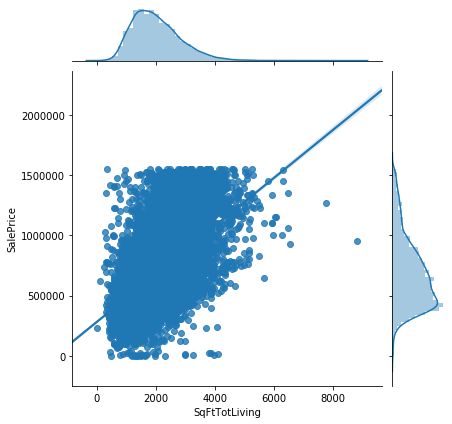

In [56]:
sns.jointplot(data=sm_3_df, x='SqFtTotLiving', y='SalePrice', kind="reg");

So, removing outliers using IQR seems to help zoom in the most dense interval of our data...

In [57]:
# `sm_3_df`
outcome = 'SalePrice'
predictors = get_predictors(sm_3_df, outcome)
formula = create_formula(outcome, predictors)
sm_3 = ols(formula=formula, data=sm_3_df).fit()
sm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     7633.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:56:47   Log-Likelihood:            -2.3657e+05
No. Observations:               17130   AIC:                         4.731e+05
Df Residuals:                   17128   BIC:                         4.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.809e+05   4959.120     56.641      0.000    2.71e+05    2.91e+05
SqFtTotLiving   199.1119      2.279     87.368      0.000     194.645     203.579
==============================================================================
Omnibus:                      878.641   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1038.380
Skew:                           0.558   Prob(JB):                    3.30e-226
Kurtosis:                       3.460   Cond. No.                     5.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		0.991 		0.657
(Normality) Jarque-Bera Test 		1038.38 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.0


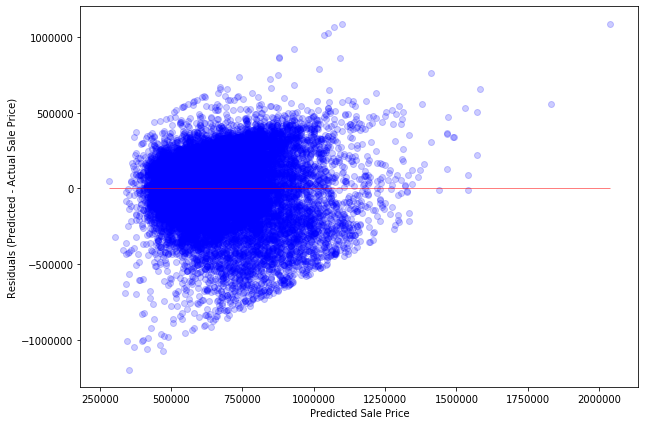

In [58]:
check_lr_assumptions(sm_3, sm_3_df, outcome, predictors)

In [59]:
append_results('sm_3', formula, sm_3, sm_3_df, outcome, predictors, 
               note='remove SalePrice outliers w/ IQR')

Model                              Formula  R-Squared  \
0         sm_1            SalePrice ~ SqFtTotLiving   0.386491   
1         sm_2            SalePrice ~ SqFtTotLiving   0.399934   
2     sm_2_log    log_SalePrice ~ log_SqFtTotLiving   0.291863   
3    sm_2_sqrt  sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4  sm_2_sqrt_2       SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5         sm_3            SalePrice ~ SqFtTotLiving   0.308273   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...  
5                   remove SalePrice outliers w/ IQR

Well, removing outliers with IQR has lower R-Squared compared to my baseline model `sm_1`. It still meets the Linearity Assumption, although `sm_3`'s Rainbow Test p-value is 0.6565131, which is smaller than `sm_2`'s.

In [60]:
model_results.sort_values(by='R-Squared', ascending=False)

Model                              Formula  R-Squared  \
1         sm_2            SalePrice ~ SqFtTotLiving   0.399934   
0         sm_1            SalePrice ~ SqFtTotLiving   0.386491   
3    sm_2_sqrt  sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4  sm_2_sqrt_2       SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5         sm_3            SalePrice ~ SqFtTotLiving   0.308273   
2     sm_2_log    log_SalePrice ~ log_SqFtTotLiving   0.291863   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
1           1.027984     9.517113e-02            Satisfied   
0           0.872905     1.000000e+00            Satisfied   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   
2           1.352501     1.084791e-46             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
1           8.752700e+03         0.000000e+00             Violated   
0           1.305055e+07         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
2           3.094762e+06         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
1                          NaN         0.000000e+00   
0                          NaN         3.931011e-82   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
1                    Violated               N/A                     N/A   
0                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   

                                                Note  
1             remove SalePrice outliers with z-score  
0                        with outliers, no transform  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...  
5                   remove SalePrice outliers w/ IQR  
2  remove SalePrice outliers w/ z-scores then log...

Based on these results, **`sm_2`** is *currently the best performing model* with an R-squared of 0.399934, which means it is able to explain about 40% the variance of our target variable `SalePrice`.

Both Intercept and `SqFtTotLiving` coefficients are statistically significant (p-values around 0.000 < 0.05).

- The `sm_2` model is currently predicting a sale price of USD 161600.0 when total living space is 0 sqft, which seems rather weird?
- And with an increase of 1 sqft in living space, the sale price is expected to increase by USD 276.8171, which is a lot lower than the first simple model's coefficient for `SqFtTotLiving`.

### Adding another Feature

For our second numeric feature, ideally I'll need something with high correlation with `SalePrice`, yet low correlation with `SqFtTotLiving` to avoid multicollinearity problems.

But first, I'll apply z-score outliers removal function on our master `df_1` dataset based on `SalePrice` since it seems to be the best course of action as of now. 

In [61]:
df_2 = remove_outliers_z(df_1, 'SalePrice')

And then I'll check the correlation between variables in this new dataset `df3` again to see if there's any differences compared to `df2`.

In [62]:
corr2 = df_2.corr()
corr2.SalePrice.sort_values(ascending=False)

SalePrice             1.000000
SqFtTotLiving         0.632403
SqFt2ndFloor          0.400375
SqFt1stFloor          0.369726
BathFullCount         0.346514
Bedrooms              0.312480
Stories               0.301886
SqFtFinBasement       0.252031
SqFtOpenPorch         0.240444
SqFtTotBasement       0.238227
SqFtDeck              0.212561
BathHalfCount         0.203739
Bath3qtrCount         0.198179
SqFtGarageAttached    0.172199
AddnlCost             0.118062
YrBuilt               0.104456
YrRenovated           0.102114
SqFtUpperFloor        0.101246
SqFtHalfFloor         0.091862
SqFtLot               0.084739
BrickStone            0.079636
SqFtGarageBasement    0.062253
LotDepthFactor        0.048950
PcntComplete          0.041430
NbrBldgSites          0.020334
SqFtEnclosedPorch     0.015375
NbrLivingUnits        0.014461
PcntUnusable          0.013095
SqFtUnfinHalf         0.008132
PcntNetCondition     -0.007648
SqFtUnfinFull        -0.011627
Name: SalePrice, dtype: float64

In [63]:
corr2.SqFtTotLiving.sort_values(ascending=False)

SqFtTotLiving         1.000000
SqFt1stFloor          0.648326
SqFt2ndFloor          0.641385
SalePrice             0.632403
Bedrooms              0.631567
BathFullCount         0.565443
SqFtGarageAttached    0.464129
SqFtFinBasement       0.386580
Stories               0.380802
YrBuilt               0.359810
BathHalfCount         0.336861
SqFtOpenPorch         0.326387
SqFtTotBasement       0.271464
AddnlCost             0.253004
Bath3qtrCount         0.232125
SqFtDeck              0.225764
SqFtLot               0.177859
SqFtGarageBasement    0.071390
SqFtHalfFloor         0.039799
YrRenovated           0.033703
NbrLivingUnits        0.025486
PcntComplete          0.020955
SqFtUpperFloor        0.019272
PcntUnusable          0.015083
BrickStone            0.010717
LotDepthFactor        0.004630
SqFtUnfinHalf         0.000045
NbrBldgSites         -0.001237
SqFtUnfinFull        -0.002966
SqFtEnclosedPorch    -0.006728
PcntNetCondition     -0.009880
Name: SqFtTotLiving, dtype: float64

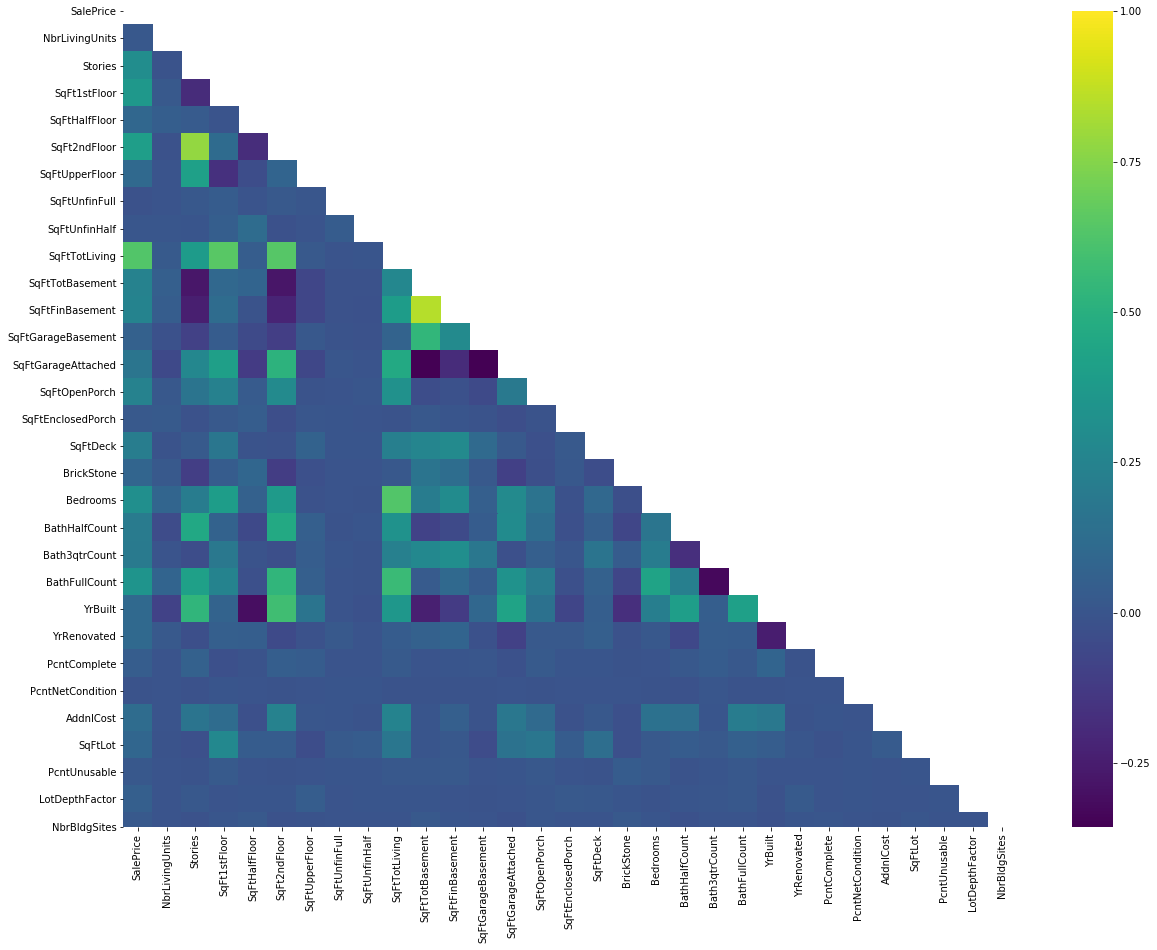

In [65]:
corr_heatmap(corr2)

If we're using a correlation threshold of +/- 0.7 to assess the relationship between 2 variables, none of the other variables would be considered "highly correlated" with `SqFtTotLiving` as of now, with `SqFt1stFloor` being at 0.670466 which is honestly speaking very close to the threshold. 

Comparing between the 2 correlation tables using `SalePrice` and `SqFtTotLiving`, I think I will go with `SqFtOpenPorch` being my second feature because it has a correlation of 0.279959 with `SalePrice`, which is on the higher side of the list, and a correlation of 0.397021 with `SqFtTotLiving`, which is still less than 0.5 (these thresholds I'm using are arbitrary --> worth experimenting with later)

In [64]:
model_2_df = df_2[['SalePrice', 'SqFtTotLiving', 'SqFtOpenPorch']].copy()

In [65]:
model_2_df.isna().sum()

SalePrice        0
SqFtTotLiving    0
SqFtOpenPorch    0
dtype: int64

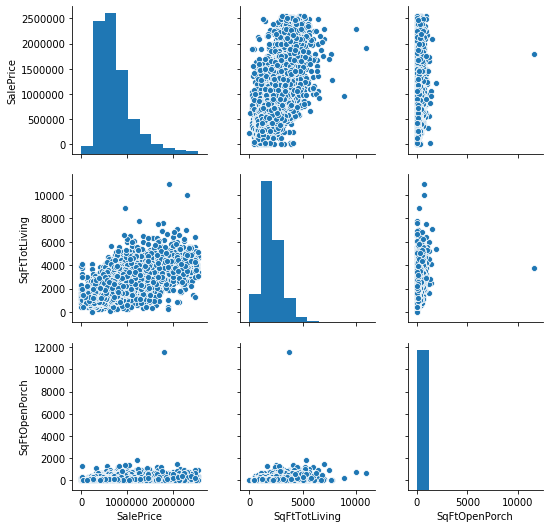

In [66]:
sns.pairplot(model_2_df);

So, the relationship between `SqFtOpenPorch` and `SalePrice` seems linear, but the line seems almost parallel to y-axis (meaning the function might be very close to something like $x = a$).

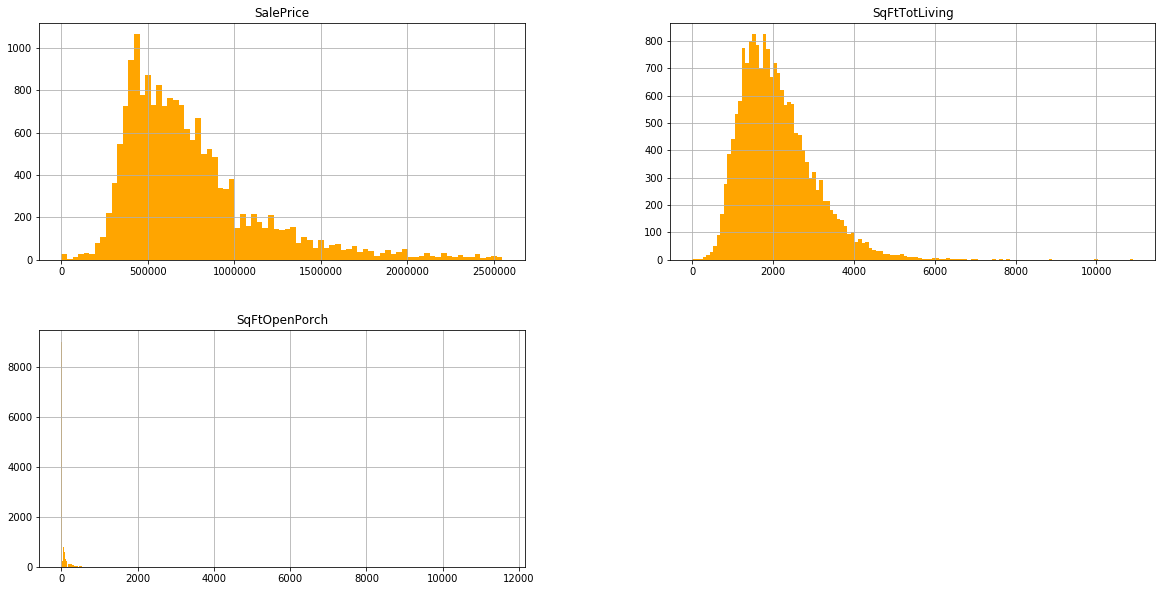

In [67]:
model_2_df.hist(figsize=(20,10), color='orange', bins='auto');

In [68]:
model_2_df.describe()

SalePrice  SqFtTotLiving  SqFtOpenPorch
count  1.801500e+04   18015.000000   18015.000000
mean   7.437521e+05    2103.026533      69.888981
std    3.926256e+05     896.973439     143.314004
min    1.000000e+01       2.000000       0.000000
25%    4.650000e+05    1444.500000       0.000000
50%    6.500000e+05    1950.000000       0.000000
75%    8.900000e+05    2590.000000     100.000000
max    2.550000e+06   10910.000000   11570.000000

In [69]:
model_2_df.SqFtOpenPorch.value_counts()

0       9030
40       924
50       785
60       764
80       605
        ... 
760        1
1080       1
153        1
217        1
335        1
Name: SqFtOpenPorch, Length: 295, dtype: int64

`SqFtOpenPorch` is heavily right skewed, it might benefit from some sort of transformations. However, since it seems like a good number of `SqFtOpenPorch` is 0, there will be problems with log transformation and inversing. Let's see if getting the square root will reduce skewness.

In [70]:
model_2_sqrt_df = sq_rt(['SqFtOpenPorch'], model_2_df)

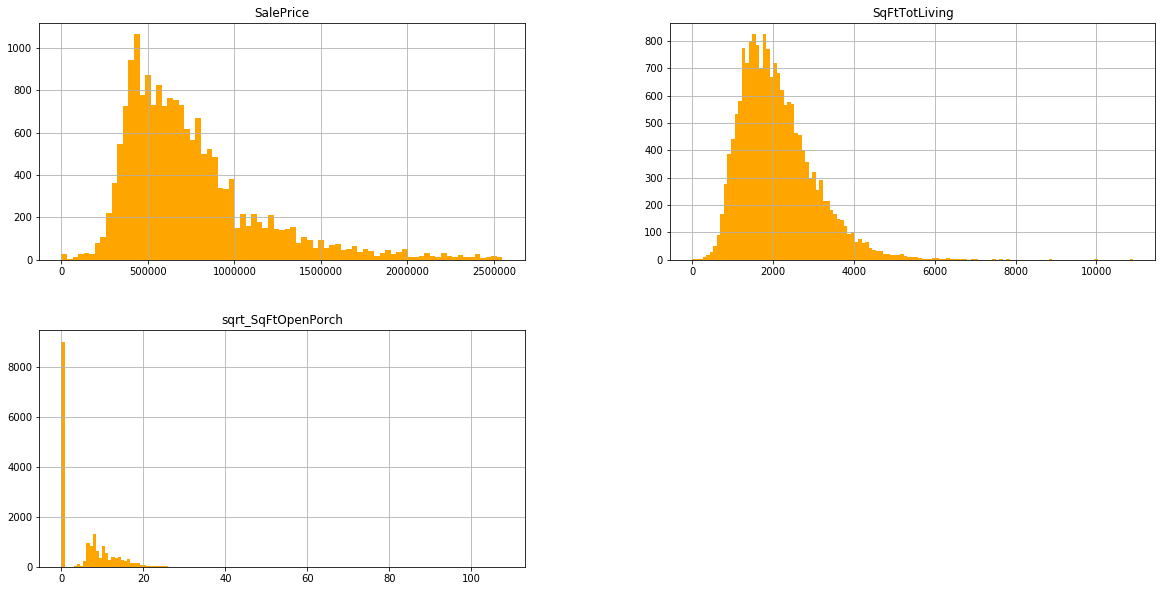

In [71]:
model_2_sqrt_df.hist(figsize=(20,10), color='orange', bins='auto');

Hmm... this still doesn't look too good :D, but let's just see how fitting a model to this dataset turns out. 

In [72]:
# `model_2_sqrt_df`
outcome = 'SalePrice'
predictors = get_predictors(model_2_sqrt_df, 'SalePrice')
formula = create_formula(outcome, predictors)
model_2_sqrt = ols(formula=formula, data=model_2_sqrt_df).fit()
model_2_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     6031.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:03:00   Log-Likelihood:            -2.5299e+05
No. Observations:               18015   AIC:                         5.060e+05
Df Residuals:                   18012   BIC:                         5.060e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            1.63e+05   5775.696     28.218      0.000    1.52e+05    1.74e+05
SqFtTotLiving        270.2646      2.761     97.872      0.000     264.852     275.677
sqrt_SqFtOpenPorch  2281.3525    389.925      5.851      0.000    1517.062    3045.643
==============================================================================
Omnibus:                     3402.857   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8651.622
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                       5.683   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.026 		0.108
(Normality) Jarque-Bera Test 		8651.622 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0

Independence:
              feature       VIF
0       SqFtTotLiving  2.069662
1  sqrt_SqFtOpenPorch  2.069662


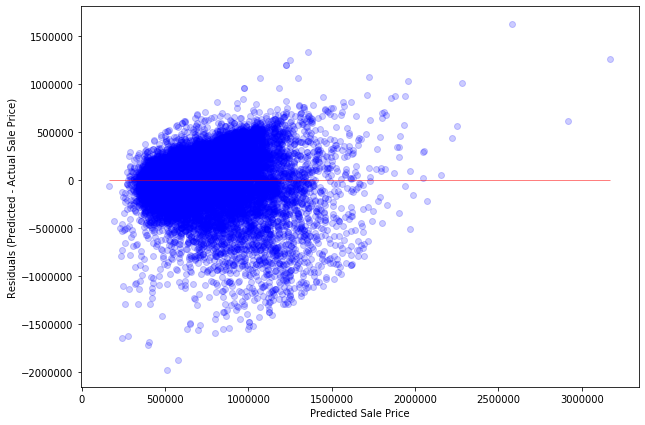

In [73]:
check_lr_assumptions(model_2_sqrt, model_2_sqrt_df, outcome, predictors)

In [74]:
append_results('model_2_sqrt', formula, model_2_sqrt, model_2_sqrt_df, outcome, predictors,
               note='remove outliers w/ z-score & get sqrt of open porch')

Model                                         Formula  R-Squared  \
0          sm_1                       SalePrice ~ SqFtTotLiving   0.386491   
1          sm_2                       SalePrice ~ SqFtTotLiving   0.399934   
2      sm_2_log               log_SalePrice ~ log_SqFtTotLiving   0.291863   
3     sm_2_sqrt             sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4   sm_2_sqrt_2                  SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5          sm_3                       SalePrice ~ SqFtTotLiving   0.308273   
6  model_2_sqrt  SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   0.401072   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   
6           1.026429     1.079098e-01            Satisfied   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
6           8.651622e+03         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
6                          0.0         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   
6                    Violated                                 Satisfied   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...  
5                   remove SalePrice outliers w/ IQR  
6  remove outliers w/ z-score & get sqrt of open ...

In [75]:
model_results.sort_values(by='R-Squared', ascending=False)

Model                                         Formula  R-Squared  \
6  model_2_sqrt  SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   0.401072   
1          sm_2                       SalePrice ~ SqFtTotLiving   0.399934   
0          sm_1                       SalePrice ~ SqFtTotLiving   0.386491   
3     sm_2_sqrt             sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4   sm_2_sqrt_2                  SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5          sm_3                       SalePrice ~ SqFtTotLiving   0.308273   
2      sm_2_log               log_SalePrice ~ log_SqFtTotLiving   0.291863   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
6           1.026429     1.079098e-01            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
0           0.872905     1.000000e+00            Satisfied   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   
2           1.352501     1.084791e-46             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
6           8.651622e+03         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
0           1.305055e+07         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
2           3.094762e+06         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
6                          0.0         0.000000e+00   
1                          NaN         0.000000e+00   
0                          NaN         3.931011e-82   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
6                    Violated                                 Satisfied   
1                    Violated               N/A                     N/A   
0                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   

                                                Note  
6  remove outliers w/ z-score & get sqrt of open ...  
1             remove SalePrice outliers with z-score  
0                        with outliers, no transform  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...  
5                   remove SalePrice outliers w/ IQR  
2  remove SalePrice outliers w/ z-scores then log...

Including the square root of `SqFtOpenPorch` has improved the R-squared by a little tiny bit. This model satisfies the Linearity as well as Independence Assumption; but it still violates the other 2 (Normality & Homoskedasticity). The coefficients for Intercept and both predictors are statistically significant. 

Based on these results, `model_2_sqrt` is currently the best performing model with an R-squared of **0.401072**, which means it is able to explain about 40.1% the variance of our target variable SalePrice.

- The `model_2_sqrt` model is currently predicting a sale price of USD 163000.0 when both total living space and `sqrt_SqFtOpenPorch` are 0, and also slightly higher than the predicted price for 0 sqft by the previous best performing model `sm_2`.
- And with an increase of 1 sqft in living space (while keeping `sqrt_SqFtOpenPorch` constant), the sale price is expected to increase by USD 270.2646, which is also lower than the `fsm_2` model.
- An increase of 1 "foot"(?) in `sqrt_SqFtOpenPorch` (while keeping `SqFtTotLiving` constant) would increase sale price by USD 2281.3525.

Now I'm curious how getting the square root of all 3 variables would turn out. Let's see.

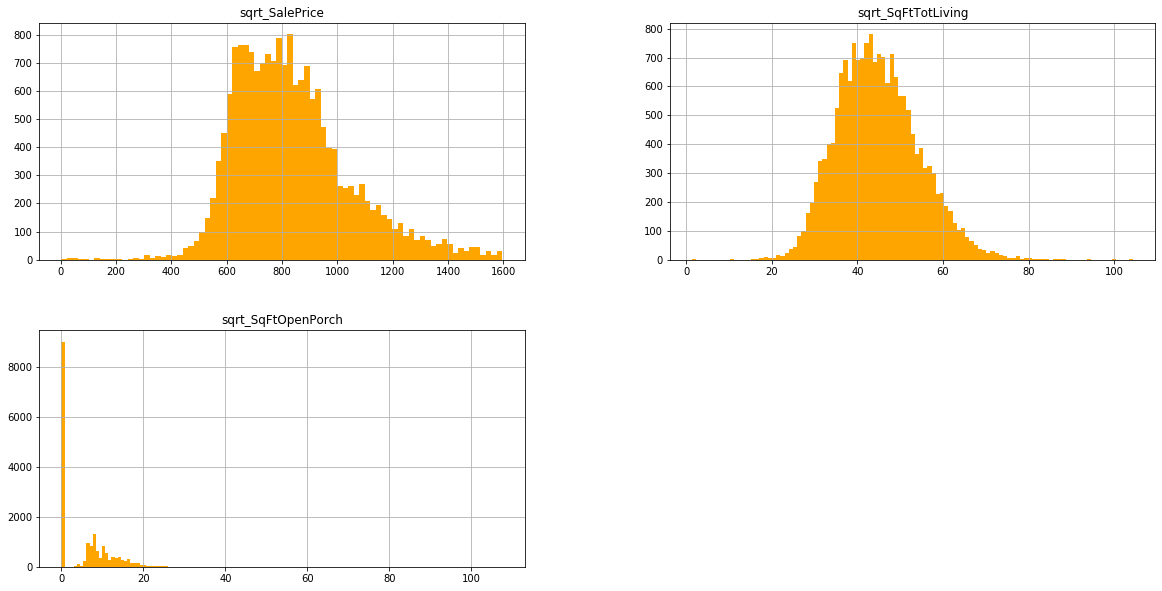

In [76]:
model_2_sqrt_all_df = sq_rt(model_2_df.columns, model_2_df)
model_2_sqrt_all_df.hist(figsize=(20,10), color='orange', bins='auto');

In [77]:
# `model_2_sqrt_all_df`
outcome = 'sqrt_SalePrice'
predictors = get_predictors(model_2_sqrt_all_df, outcome)
formula = create_formula(outcome, predictors)
model_2_sqrt_all = ols(formula=formula, data=model_2_sqrt_all_df).fit()
model_2_sqrt_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_SalePrice   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     5537.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:05:41   Log-Likelihood:            -1.1759e+05
No. Observations:               18015   AIC:                         2.352e+05
Df Residuals:                   18012   BIC:                         2.352e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            232.5626      6.121     37.995      0.000     220.565     244.560
sqrt_SqFtTotLiving    13.2895      0.142     93.779      0.000      13.012      13.567
sqrt_SqFtOpenPorch     1.3892      0.211      6.570      0.000       0.975       1.804
==============================================================================
Omnibus:                      827.878   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1487.554
Skew:                           0.367   Prob(JB):                         0.00
Kurtosis:                       4.202   Cond. No.                         230.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.051 		0.009
(Normality) Jarque-Bera Test 		1487.554 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0

Independence:
              feature       VIF
0  sqrt_SqFtTotLiving  1.952552
1  sqrt_SqFtOpenPorch  1.952552


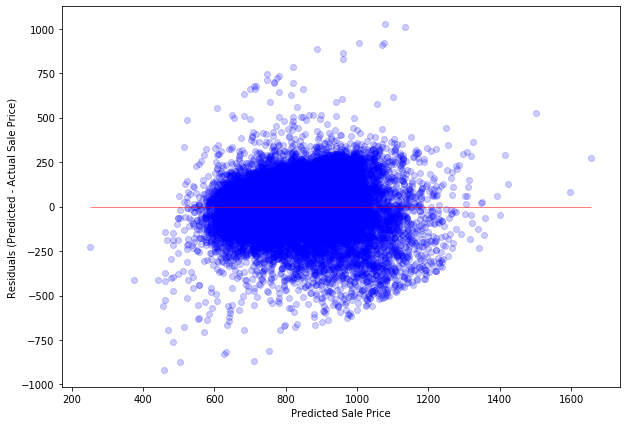

In [78]:
check_lr_assumptions(model_2_sqrt_all, model_2_sqrt_all_df, outcome, predictors)

In [82]:
append_results('model_2_sqrt_all', formula, model_2_sqrt_all, model_2_sqrt_all_df, outcome, predictors,
               note='remove saleprice outliers w/ z-score & get sqrt of all vars')

Model                                            Formula  \
0              sm_1                          SalePrice ~ SqFtTotLiving   
1              sm_2                          SalePrice ~ SqFtTotLiving   
2          sm_2_log                  log_SalePrice ~ log_SqFtTotLiving   
3              sm_3                          SalePrice ~ SqFtTotLiving   
4         sm_2_sqrt                sqrt_SalePrice ~ sqrt_SqFtTotLiving   
5       sm_2_sqrt_2                     SalePrice ~ sqrt_SqFtTotLiving   
6      model_2_sqrt     SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   
7  model_2_sqrt_all  sqrt_SalePrice ~ sqrt_SqFtTotLiving + sqrt_SqF...   

   R-Squared  Rainbow statistic  Rainbow p-value Linearity Assumption  \
0   0.386491           0.872905     1.000000e+00            Satisfied   
1   0.399934           1.027984     9.517113e-02            Satisfied   
2   0.291863           1.352501     1.084791e-46             Violated   
3   0.308273           0.991329     6.565131e-01            Satisfied   
4   0.379239           1.053338     6.839964e-03             Violated   
5   0.375599           1.033779     5.747716e-02            Satisfied   
6   0.401072           1.026429     1.079098e-01            Satisfied   
7   0.380722           1.051251     8.860869e-03             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.038380e+03        3.300538e-226             Violated   
4           1.509920e+03         0.000000e+00             Violated   
5           8.842146e+03         0.000000e+00             Violated   
6           8.651622e+03         0.000000e+00             Violated   
7           1.487554e+03         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
6                          0.0         0.000000e+00   
7                          0.0         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   
6                    Violated                                 Satisfied   
7                    Violated                                 Satisfied   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3                   remove SalePrice outliers w/ IQR  
4  remove SalePrice outliers w/ z-score & sqrt tr...  
5  remove SalePrice outliers w/ z-score & sqrt on...  
6  remove outliers w/ z-score & get sqrt of open ...  
7  remove saleprice outliers w/ z-score & get sqr...

So far, `model_2_sqrt` is still the best performing one, so I'll stick with that.

However, since `SqFtOpenPorch` has a lot of 0 valued datapoints. I wonder if treating it as a categorical feature would make more sense. I can create another column that keeps track of whether a house has an open porch or not using (1/0) to see how it goes.

In [79]:
# create a function that convert x to binary 0/1
# output would be similar to LabelEncoder
def convert_to_binary(x):
    return 1 if x > 0 else 0

In [80]:
model_2_df['has_OpenPorch'] = model_2_df.SqFtOpenPorch.apply(convert_to_binary)

In [82]:
model_2_cat_df = model_2_df.drop('SqFtOpenPorch', axis=1)

In [83]:
model_2_cat_df.head()

SalePrice  SqFtTotLiving  has_OpenPorch
0      560000           1930              1
1      435000           1975              1
8      648500           3300              0
11     380000           1750              1
14     930000           2580              1

In [84]:
# `model_2_cat_df`
outcome = 'SalePrice'
predictors = get_predictors(model_2_cat_df, outcome)
formula = create_formula(outcome, predictors)
model_2_cat = ols(formula=formula, data=model_2_cat_df).fit()
model_2_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     6012.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:06:32   Log-Likelihood:            -2.5300e+05
No. Observations:               18015   AIC:                         5.060e+05
Df Residuals:                   18012   BIC:                         5.060e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.597e+05   5801.591     27.531      0.000    1.48e+05    1.71e+05
SqFtTotLiving   273.8986      2.672    102.525      0.000     268.662     279.135
has_OpenPorch  1.607e+04   4792.446      3.353      0.001    6673.033    2.55e+04
==============================================================================
Omnibus:                     3422.505   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8742.264
Skew:                           1.044   Prob(JB):                         0.00
Kurtosis:                       5.699   Cond. No.                     5.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		1.027 		0.1
(Normality) Jarque-Bera Test 		8742.264 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0

Independence:
         feature       VIF
0  SqFtTotLiving  2.211267
1  has_OpenPorch  2.211267


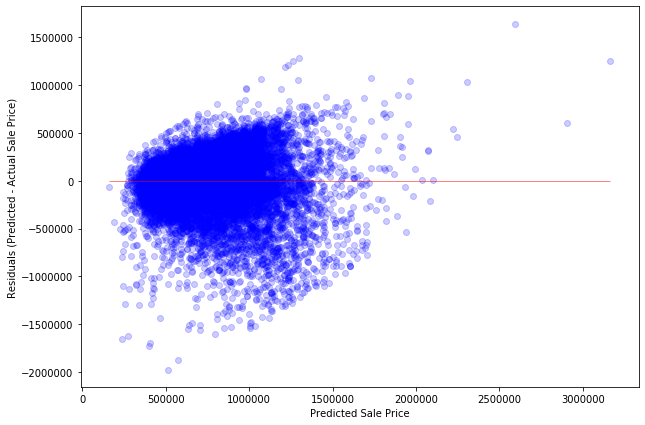

In [85]:
check_lr_assumptions(model_2_cat, model_2_cat_df, outcome, predictors)

In [86]:
append_results('model_2_cat', formula, model_2_cat, model_2_cat_df, outcome, predictors,
               note='remove saleprice outliers w/ z-score & convert open porch to binary')

Model                                         Formula  R-Squared  \
0          sm_1                       SalePrice ~ SqFtTotLiving   0.386491   
1          sm_2                       SalePrice ~ SqFtTotLiving   0.399934   
2      sm_2_log               log_SalePrice ~ log_SqFtTotLiving   0.291863   
3     sm_2_sqrt             sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4   sm_2_sqrt_2                  SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5          sm_3                       SalePrice ~ SqFtTotLiving   0.308273   
6  model_2_sqrt  SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   0.401072   
7   model_2_cat       SalePrice ~ SqFtTotLiving + has_OpenPorch   0.400308   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   
6           1.026429     1.079098e-01            Satisfied   
7           1.027403     9.979305e-02            Satisfied   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
6           8.651622e+03         0.000000e+00             Violated   
7           8.742264e+03         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
6                          0.0         0.000000e+00   
7                          0.0         0.000000e+00   

  Homoskedasticity Assumption Multicollinearity Independence Assumption  \
0                    Violated               N/A                     N/A   
1                    Violated               N/A                     N/A   
2                    Violated               N/A                     N/A   
3                    Violated               N/A                     N/A   
4                    Violated               N/A                     N/A   
5                    Violated               N/A                     N/A   
6                    Violated                                 Satisfied   
7                    Violated                                 Satisfied   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers w/ z-scores then log...  
3  remove SalePrice outliers w/ z-score & sqrt tr...  
4  remove SalePrice outliers w/ z-score & sqrt on...  
5                   remove SalePrice outliers w/ IQR  
6  remove outliers w/ z-score & get sqrt of open ...  
7  remove saleprice outliers w/ z-score & convert...

Among all the versions of `model_2`, getting the square root of `SqFtOpenPorch` is still the best performing one with an R-squared of 0.401072. Although converting that same feature to categorical is also coming in close second with an R-squared of 0.400308. Yet `model_2_cat` has lower p-value for Rainbow test (but still satisfies the Linearity assumption).

## Multiple Regresion

Randomly selecting features to add into our model is not going to be helpful when I have 60 columns as of now. Ideally, I would like to do scatter plot for all numeric predictors vs. `SalePrice` to see if there are any polynomial relationship that correlation might not reflect. 

In addition, there's also the possibility of interaction between different features that I need to consider.

Removing outliers using z-score seems to have produced good results so far, so I will proceed forward with the `df_2` dataset for now to see where it takes me.

In [87]:
def get_numeric_features(df):
    numeric_features = []
    for c in df.columns:
        if (df[c].dtype == 'int64' or df[c].dtype == 'float64') and c != 'SalePrice':
            numeric_features.append(c)
    return numeric_features

In [88]:
def scatterplot_feats_outcome(df, features, outcome):
    """
    # Visualizing the relationship between all numeric_features with target variable 'outcome' 
    using scatter plots in the dataframe 'df'
    """
    nrows = len(features) // 3
    nrows += 1 if (len(features) % 3 != 0) else 0
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(21,nrows*5))
    for idx, f in enumerate(features):
        ax = axes[idx // 3][idx % 3]
        sns.scatterplot(data=df, x=outcome, y=f, ax=ax, color='blue', alpha=0.4)
    fig.tight_layout()
    fig.show();

I am going to convert `YrBuilt` and `YrRenovated` to duration varibles (just because in my head it makes more sense).

In [126]:
# Adding 2 more duration columns to the dataset
df_3 = df_2.copy()
df_3['Yrs_BeforeSold'] = 2019 - df_3.YrBuilt
df_3['Yrs_SinceRenovated'] = 2019 - df_3.YrRenovated

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


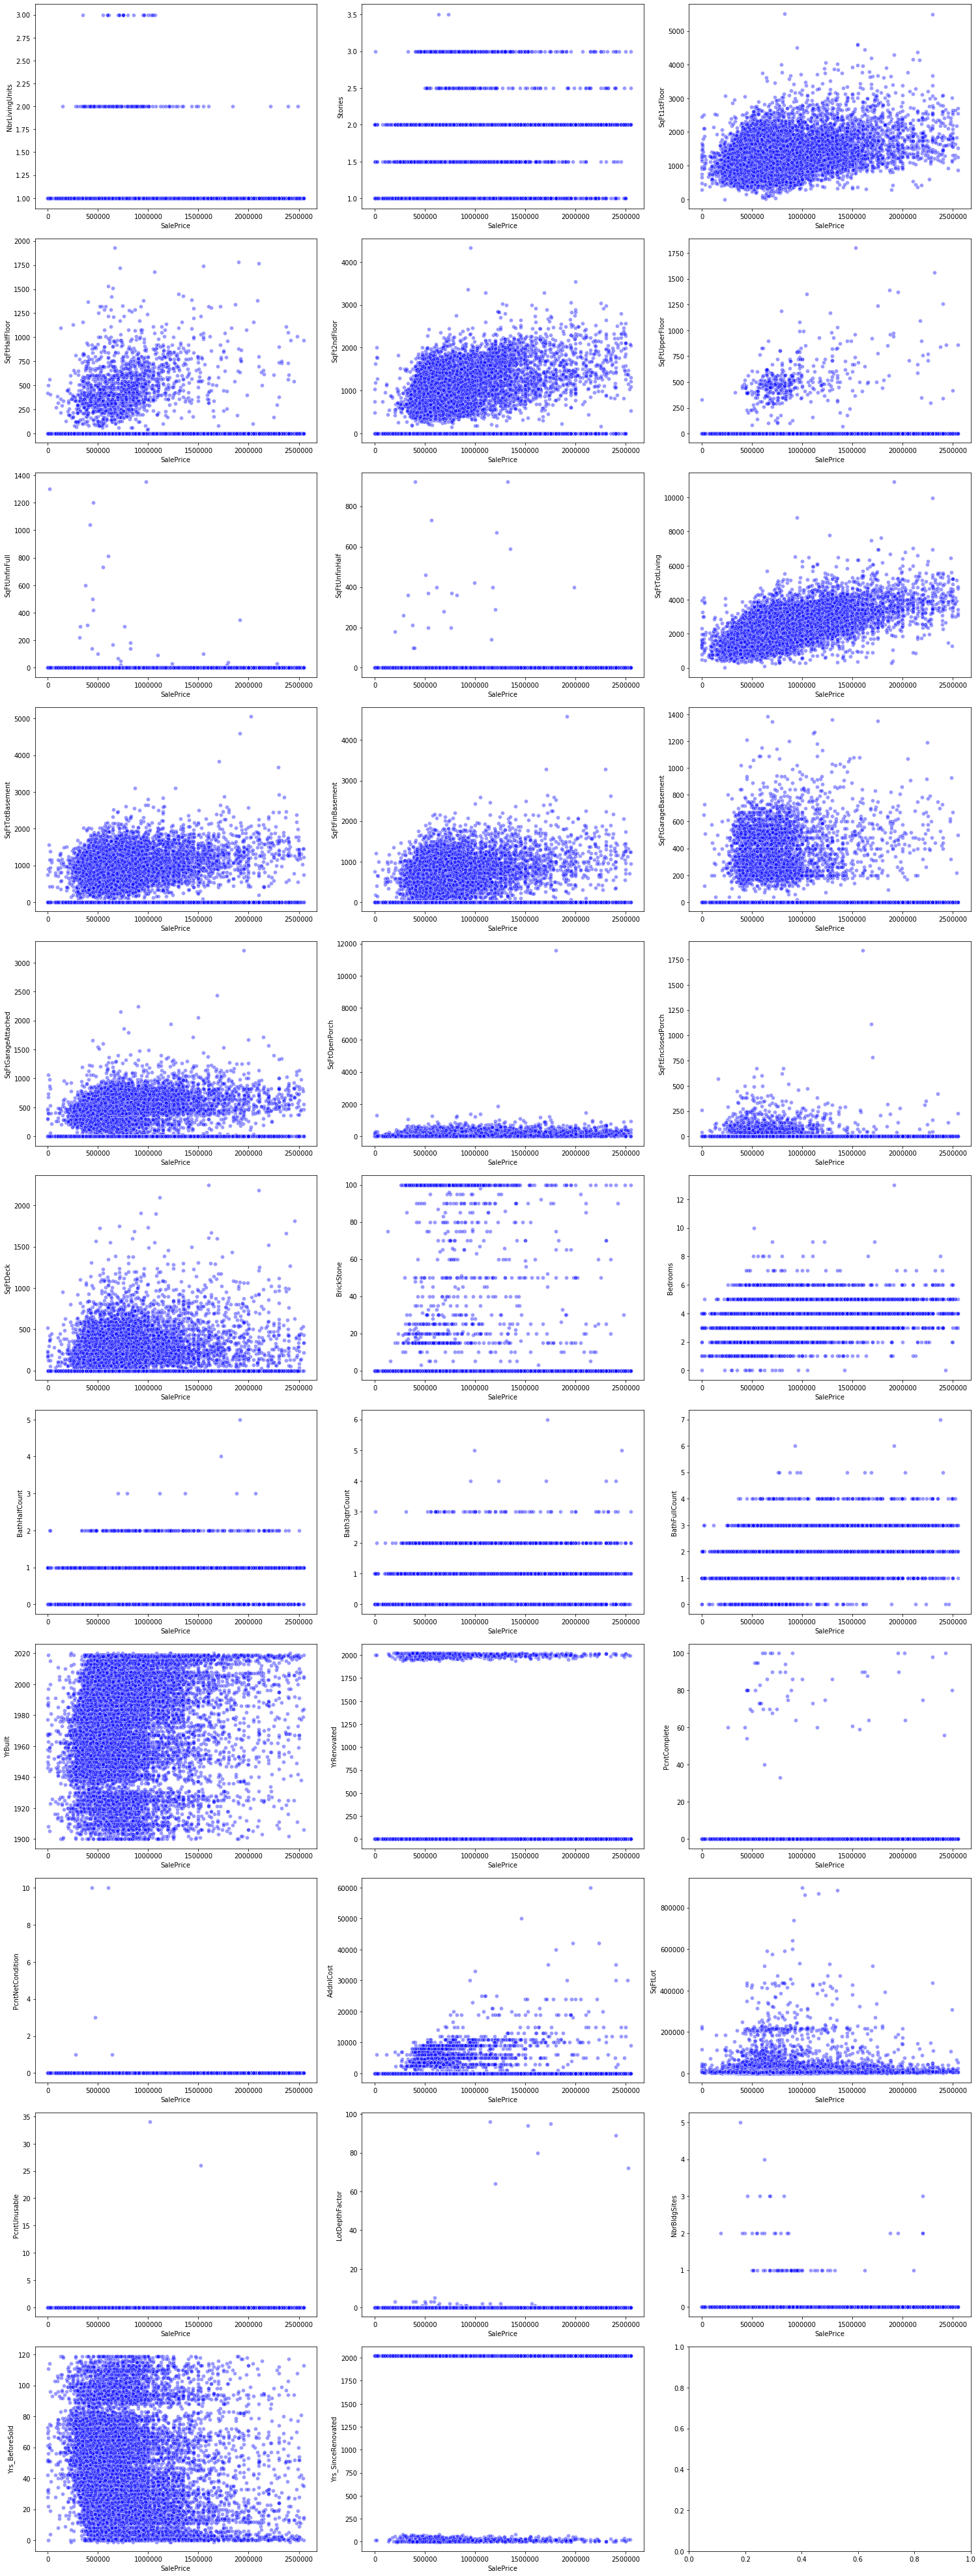

In [127]:
# getting numeric features and scatterplot them vs. 'SalePrice'
numeric_features_3 = get_numeric_features(df_3)
scatterplot_feats_outcome(df_3, numeric_features_3, 'SalePrice')

Some of these numerical valued features would need to be treated as categorical later.

Also, maybe instead of keeping track of the amount of time between a house being renovated and its sales being documented, I should consider adding another column that only stores whether a house has been renovated or not, called `been_Renovated`.

In [128]:
df_3['been_Renovated'] = df_3.YrRenovated.apply(convert_to_binary)

In [129]:
df_3.been_Renovated.value_counts()

0    17167
1      848
Name: been_Renovated, dtype: int64

Also, some other columns also have a large amount of 0 values, such as `SqFtHalfFloor`, `SqFt2ndFloor`, `SqFtTotBasement`, `SqFtFinBasement`, `SqFtGarageBasement`, `SqFtGarageAttached`, `SqFtEnclosedPorch` as well as `SqFtOpenPorch` and `SqFtDeck`. Since these area-related features are most likely correlated and can be a problem with multicollinearity, I'm thinking about converting them to binary as well. 

For example:
- `SqFtHalfFloor` would then be tranformed into `has_HalfFloor` with values of 0/1 only. 

In [130]:
to_bin_cols = ['SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtTotBasement', 'SqFtFinBasement', 'SqFtGarageBasement',
               'SqFtGarageAttached', 'SqFtEnclosedPorch', 'SqFtDeck', 'SqFtOpenPorch']
for c in to_bin_cols:
    print(c)
    print(df_3[c].value_counts())

SqFtHalfFloor
0       16425
400        57
340        50
480        39
600        37
        ...  
1720        1
1240        1
1200        1
552         1
1390        1
Name: SqFtHalfFloor, Length: 161, dtype: int64
SqFt2ndFloor
0       10069
900        95
1020       76
960        74
1360       74
        ...  
1542        1
1494        1
1446        1
1414        1
1775        1
Name: SqFt2ndFloor, Length: 578, dtype: int64
SqFtTotBasement
0       9422
1010     160
1060     138
1100     131
1200     121
        ... 
855        1
3830       1
456        1
3097       1
1711       1
Name: SqFtTotBasement, Length: 358, dtype: int64
SqFtFinBasement
0       10823
500       196
600       149
400       145
800       145
        ...  
396         1
486         1
694         1
1014        1
975         1
Name: SqFtFinBasement, Length: 318, dtype: int64
SqFtGarageBasement
0       14063
200       256
240       197
220       164
290       145
        ...  
183         1
1350        1
1270        1


As observed, all these features has the top count values being 0.

In [131]:
# create new columns 
for c in to_bin_cols:
    df_3[f'has_{c[4:]}'] = df_3[c].apply(convert_to_binary)

In [132]:
df_3.columns

Index(['PIN', 'SalePrice', 'ExciseTaxNbr', 'DocumentDate', 'RecordingNbr',
       'PropertyType', 'PropertyClass', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'Stories', 'BldgGrade', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost', 'DistrictName', 'SqFtLot', 'WaterSystem',
       'SewerSystem', 'StreetSurface', 'RestrictiveSzShape',
       'InadequateParking', 'PcntUnusable', 'LotDepthFactor', '

The followings are the the continuous columns that I want to include in my preliminary multiple regression model. Since I'm using the binary versions for some of the numeric features, I am going to exclude them from my continuous list. Maybe later I should consider treating the discrete ones, like `BathHalfCount`, `Bath3qtrCount`, `BathFullCount` and even `Bedrooms` as categoricals instead. Then that'll be a lot of columns...

In [134]:
continuous = ['SalePrice', 'SqFt1stFloor', 'SqFtTotLiving',
              'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 
              'BathFullCount', 'Yrs_BeforeSold']
df_3_cont = df_3[continuous]

# reset index for df_3_cont for concatenating with df_3_cat later
df_3_cont.index = range(len(df_3_cont))

### Converting Categorical Features using OneHotEncoder()

First I have identified the categorical columns that I think might be more relevant to the purpose of this project, and then apply `OneHotEncoder()` on them.

In [135]:
categoricals = ['Stories', 'BldgGrade', 'FinBasementGrade', 'DaylightBasement', 'HeatSystem', 
                'HeatSource', 'ViewUtilization', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding',
                'FpAdditional', 'Condition', 'WaterSystem', 'SewerSystem', 'TrafficNoise', 'Contamination',
                'WaterProblems', 'been_Renovated', 'DistrictName']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


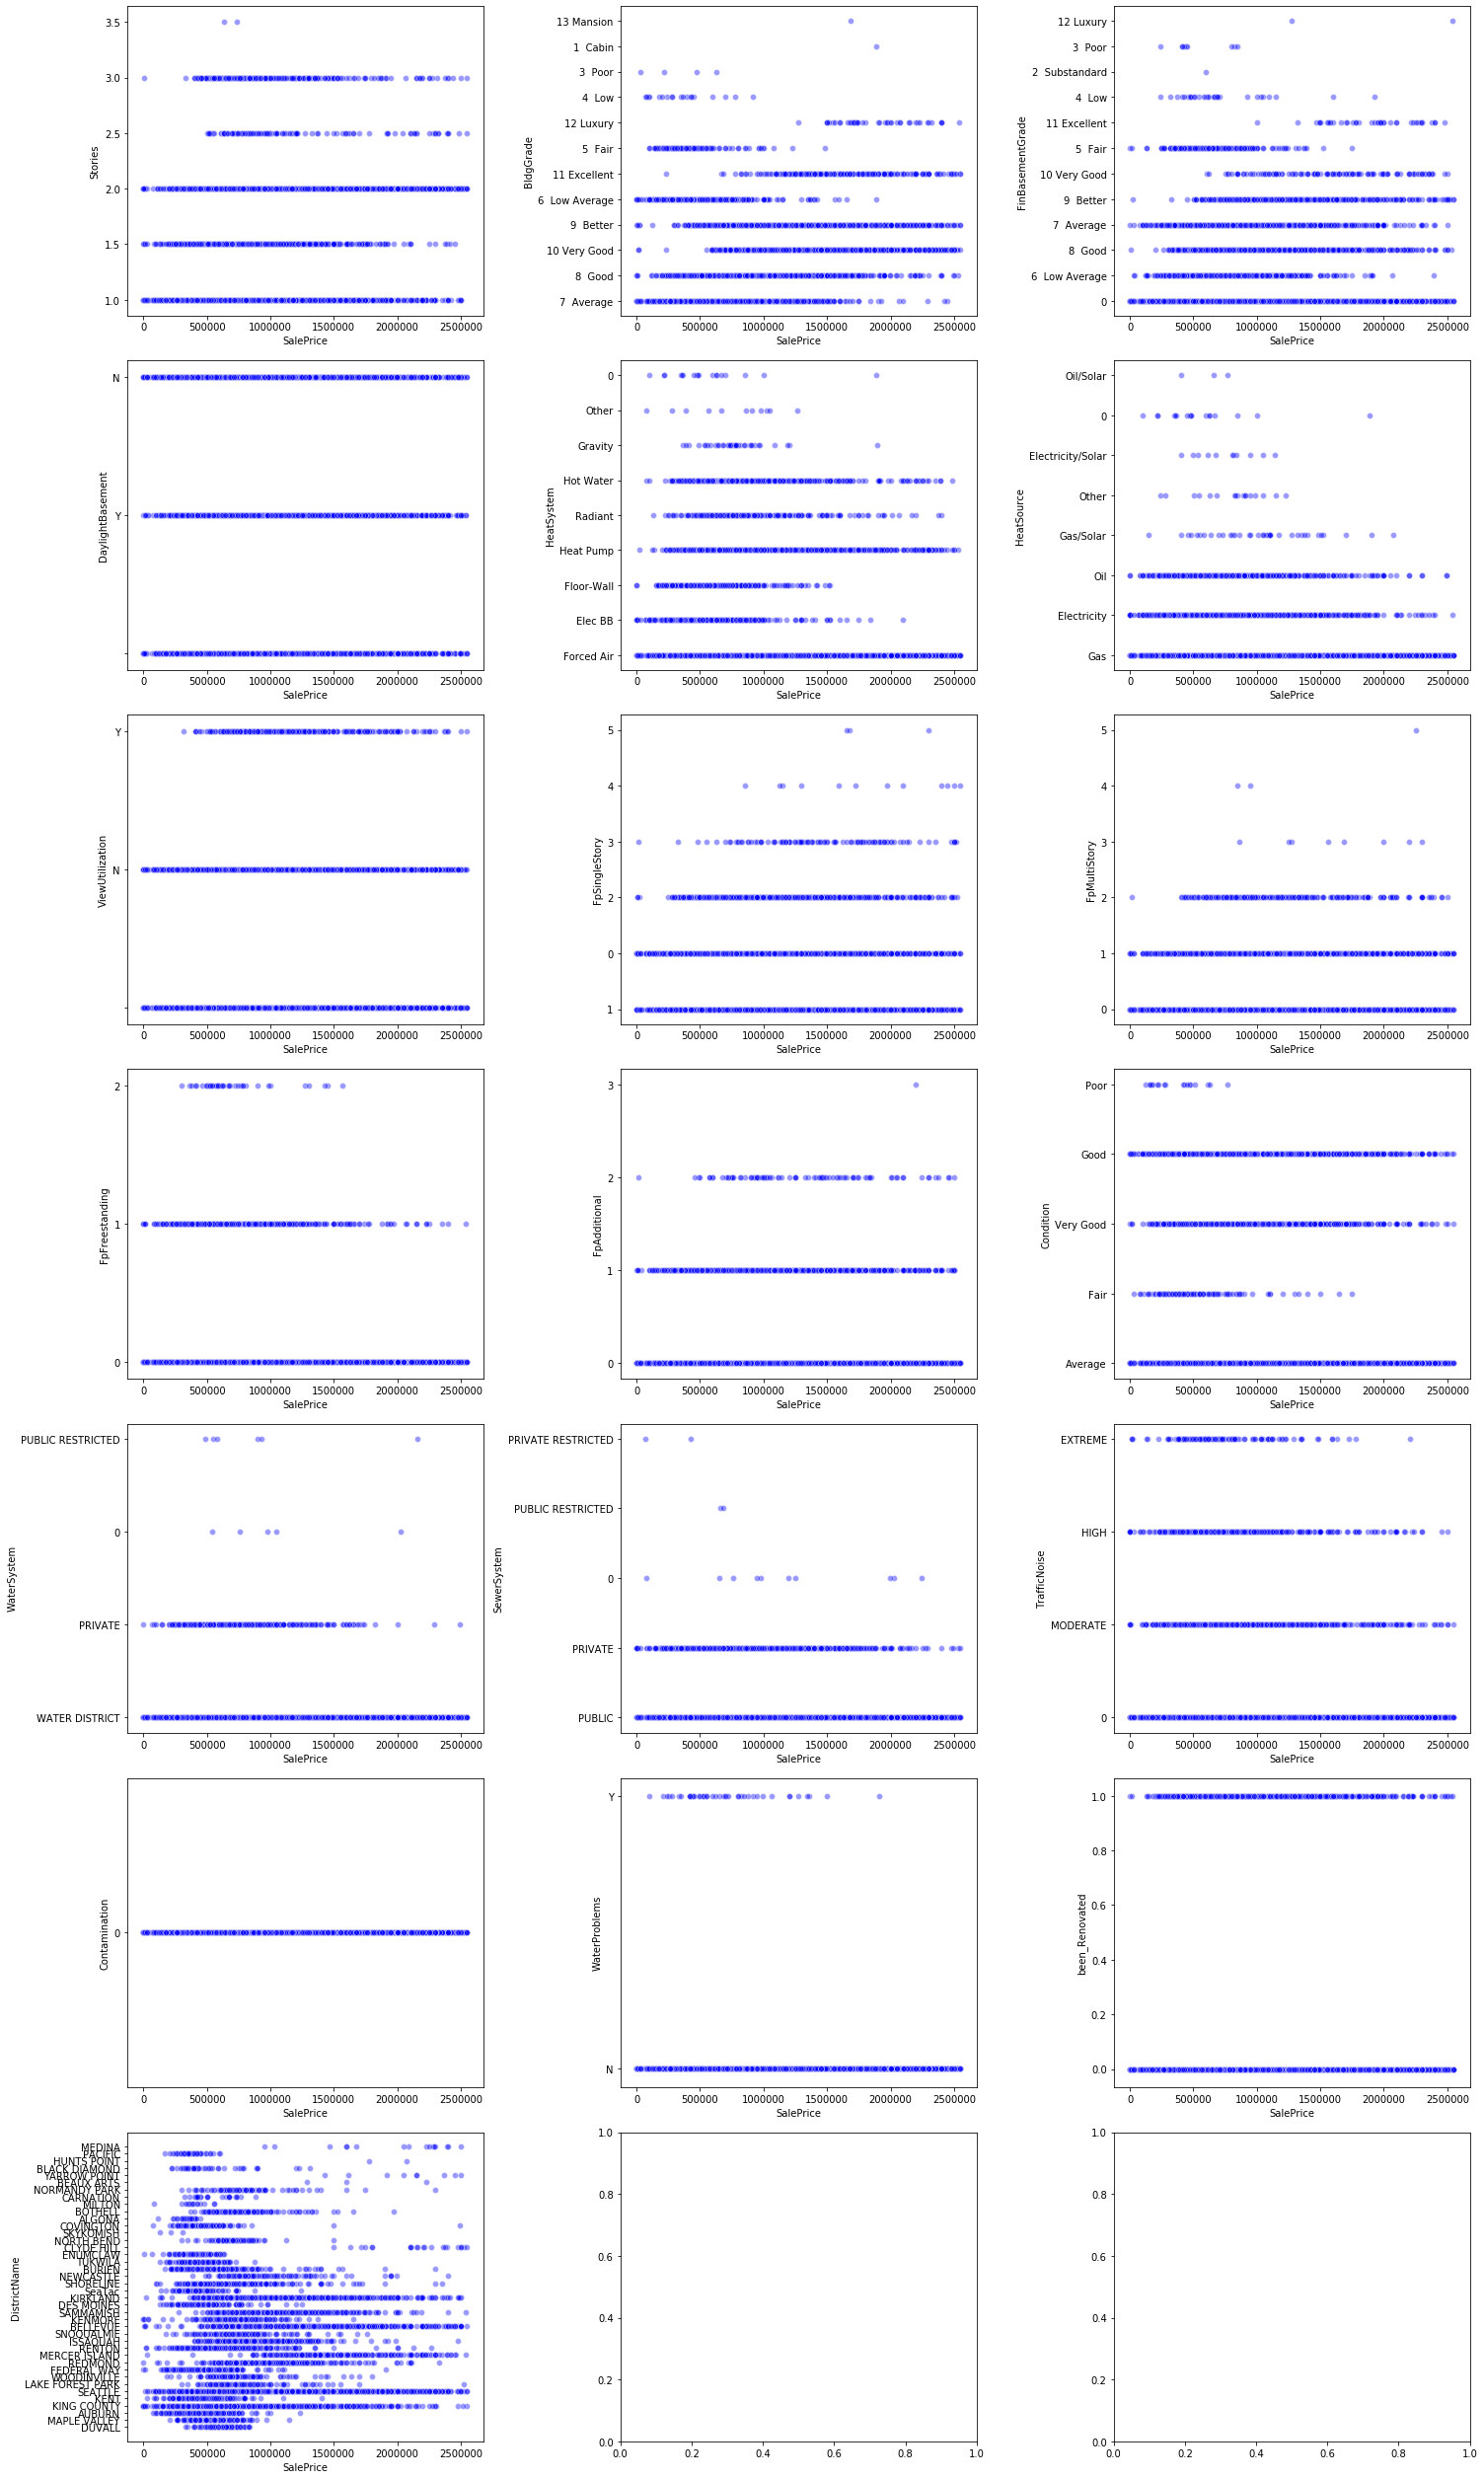

In [136]:
scatterplot_feats_outcome(df_3, categoricals, 'SalePrice')

Definitely don't need `Contamination` in this dataset, so I am going to exclude it later.

Also, `ViewUtilization` and `DaylightBasement` are kind of weird. I would assume the empty `' '` value indicates 'No', so I am going to convert those to `'N'` instead for both features (not sure if this interpretation is correct though).

In [137]:
for c in ['ViewUtilization', 'DaylightBasement']:
    df_3[c] = df_3[c].apply(lambda x: x if x in ['N', 'Y'] else 'N')

In [138]:
# Update the list of categorical features
categoricals = ['Stories', 'BldgGrade', 'FinBasementGrade', 'DaylightBasement', 'HeatSystem', 
                'HeatSource', 'ViewUtilization', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding',
                'FpAdditional', 'Condition', 'WaterSystem', 'SewerSystem', 'TrafficNoise',
                'WaterProblems', 'been_Renovated', 'has_HalfFloor', 'has_2ndFloor',
                'has_TotBasement', 'has_FinBasement', 'has_GarageBasement', 'has_OpenPorch',
                'has_GarageAttached', 'has_EnclosedPorch', 'has_Deck', 'DistrictName']

In [139]:
# Apply OneHotEncoder() on categorical predictors
ohe = OneHotEncoder(drop='first')
ohe.fit(df_3[categoricals])
ohe_trans = ohe.transform(df_3[categoricals])

# Passing 'categoricals' into .get_feature_names() will include original feature names 
# in our OHE columns later
column_names = ohe.get_feature_names(categoricals)

df_3_cat = pd.DataFrame(ohe_trans.todense(), columns=column_names)

In [140]:
# concatenate 'df_3_cont' and 'df_3_cat' to create a final version of df_3
df_3_final = pd.concat([df_3_cont, df_3_cat], axis=1)

In [141]:
# Remove all white spaces in column names to make sure we don't have problem with
# creating formula later on

# Turned out some characters like '.', '/', '-' also seem to cause problem with statsmodels R formula
# --> remove them from all the column names
df_3_final.columns = [x.replace(" ", '')
                       .replace('.', '')
                       .replace("-", "_")
                       .replace("/", "_") for x in df_3_final.columns]

In [142]:
df_3_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18015 entries, 0 to 18014
Columns: 131 entries, SalePrice to DistrictName_YARROWPOINT
dtypes: float64(123), int64(8)
memory usage: 18.0 MB


This dataset is now including 131 columns including the outcome variable. I'm just going to fit a model using all 130 predictors to see how the results look.

In [143]:
# Fitting a model including all 130 predictors
outcome = 'SalePrice'
predictors = get_predictors(df_3_final, outcome)
formula = create_formula(outcome, predictors)
model_3_full = ols(formula=formula, data=df_3_final).fit()
model_3_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     423.7
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:13:23   Log-Likelihood:            -2.4499e+05
No. Observations:               18015   AIC:                         4.902e+05
Df Residuals:                   17885   BIC:                         4.913e+05
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.318e+06   2.19e+05      6.024      0.000    8.89e+05    1.75e+06
SqFt1stFloor                    -34.4607      7.180     -4.800      0.000     -48.534     -20.387
SqFtTotLiving                   185.7211      4.928     37.690      0.000     176.062     195.380
Bedrooms                      -2.425e+04   2266.206    -10.700      0.000   -2.87e+04   -1.98e+04
BathHalfCount                  2.761e+04   3714.595      7.432      0.000    2.03e+04    3.49e+04
Bath3qtrCount                  5.021e+04   3489.933     14.388      0.000    4.34e+04    5.71e+04
BathFullCount                  4.632e+04   3752.655     12.342      0.000     3.9e+04    5.37e+04
Yrs_BeforeSold                  998.6873     98.345     10.155      0.000     805.922    1191.453
Stories_15                     5.329e+05   7.44e+04      7.160      0.000    3.87e+05    6.79e+05
Stories_20                     2.882e+05   1.97e+05      1.466      0.143   -9.71e+04    6.73e+05
Stories_25                     9.189e+05   2.11e+05      4.352      0.000    5.05e+05    1.33e+06
Stories_30                      2.86e+05   1.97e+05      1.452      0.146      -1e+05    6.72e+05
Stories_35                     8.648e+05   2.52e+05      3.431      0.001    3.71e+05    1.36e+06
BldgGrade_10VeryGood          -7.106e+05   2.04e+05     -3.482      0.000   -1.11e+06   -3.11e+05
BldgGrade_11Excellent         -5.703e+05   2.05e+05     -2.788      0.005   -9.71e+05   -1.69e+05
BldgGrade_12Luxury            -4.963e+05   2.07e+05     -2.397      0.017   -9.02e+05   -9.05e+04
BldgGrade_13Mansion           -1.069e+06   2.84e+05     -3.768      0.000   -1.63e+06   -5.13e+05
BldgGrade_3Poor               -1.084e+06   2.23e+05     -4.863      0.000   -1.52e+06   -6.47e+05
BldgGrade_4Low                -1.153e+06   2.06e+05     -5.601      0.000   -1.56e+06    -7.5e+05
BldgGrade_5Fair               -1.143e+06   2.04e+05     -5.605      0.000   -1.54e+06   -7.43e+05
BldgGrade_6LowAverage         -1.165e+06   2.04e+05     -5.716      0.000   -1.56e+06   -7.65e+05
BldgGrade_7Average             -1.11e+06   2.04e+05     -5.447      0.000   -1.51e+06   -7.11e+05
BldgGrade_8Good               -1.033e+06   2.04e+05     -5.066      0.000   -1.43e+06   -6.33e+05
BldgGrade_9Better             -8.846e+05   2.04e+05     -4.338      0.000   -1.28e+06   -4.85e+05
FinBasementGrade_10VeryGood     3.01e+04   2.78e+04      1.085      0.278   -2.43e+04    8.45e+04
FinBasementGrade_11Excellent   5.675e+04   3.76e+04      1.508      0.132    -1.7e+04    1.31e+05
FinBasementGrade_12Luxury     -3.095e+05   1.32e+05     -2.341      0.019   -5.69e+05   -5.03e+04
FinBasementGrade_2Substandard  8.186e+04   1.81e+05      0.452      0.651   -2.73e+05    4.37e+05
FinBasementGrade_3Poor          4.19e+04   6.

					Statistic 	P-value
(Linearity) Rainbow Test 		1.109 		0.0
(Normality) Jarque-Bera Test 		38709.862 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)



Independence:
                      feature        VIF
0                SqFt1stFloor  43.727270
1               SqFtTotLiving  59.734593
2                    Bedrooms  30.160918
3               BathHalfCount   3.250749
4               Bath3qtrCount   3.761713
..                        ...        ...
125   DistrictName_SNOQUALMIE   5.779316
126       DistrictName_SeaTac   4.541604
127      DistrictName_TUKWILA   3.785528
128  DistrictName_WOODINVILLE   3.880173
129  DistrictName_YARROWPOINT   1.225612

[130 rows x 2 columns]


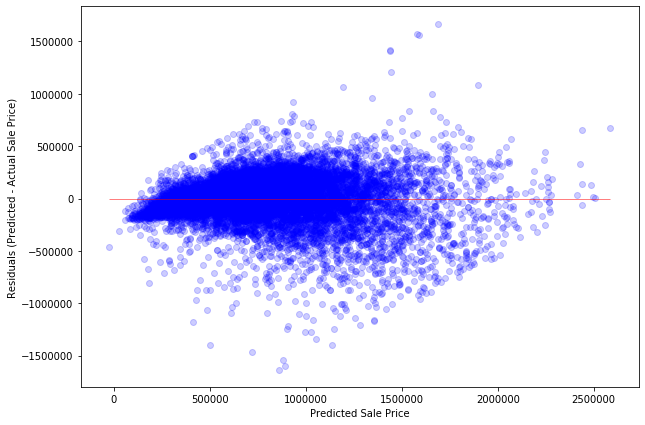

In [144]:
check_lr_assumptions(model_3_full, df_3_final, outcome, predictors)

In [145]:
append_results('model_3_full', formula, model_3_full, df_3_final, outcome, predictors, 
               note='includes all 131 features')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Model                                            Formula  R-Squared  \
0          sm_1                          SalePrice ~ SqFtTotLiving   0.386491   
1          sm_2                          SalePrice ~ SqFtTotLiving   0.399934   
2      sm_2_log                  log_SalePrice ~ log_SqFtTotLiving   0.291863   
3     sm_2_sqrt                sqrt_SalePrice ~ sqrt_SqFtTotLiving   0.379239   
4   sm_2_sqrt_2                     SalePrice ~ sqrt_SqFtTotLiving   0.375599   
5          sm_3                          SalePrice ~ SqFtTotLiving   0.308273   
6  model_2_sqrt     SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   0.401072   
7   model_2_cat          SalePrice ~ SqFtTotLiving + has_OpenPorch   0.400308   
8  model_3_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Bed...   0.753468   

   Rainbow statistic  Rainbow p-value Linearity Assumption  \
0           0.872905     1.000000e+00            Satisfied   
1           1.027984     9.517113e-02            Satisfied   
2           1.352501     1.084791e-46             Violated   
3           1.053338     6.839964e-03             Violated   
4           1.033779     5.747716e-02            Satisfied   
5           0.991329     6.565131e-01            Satisfied   
6           1.026429     1.079098e-01            Satisfied   
7           1.027403     9.979305e-02            Satisfied   
8           1.108754     5.300934e-07             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
6           8.651622e+03         0.000000e+00             Violated   
7           8.742264e+03         0.000000e+00             Violated   
8           3.870986e+04         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
6                          0.0         0.000000e+00   
7                          0.0         0.000000e+00   
8                          0.0         0.000000e+00   

  Homoskedasticity Assumption  \
0                    Violated   
1                    Violated   
2                    Violated   
3                    Violated   
4                    Violated   
5                    Violated   
6                    Violated   
7                    Violated   
8                    Violated   

                                   Multicollinearity Independence Assumption  \
0                                                N/A                     N/A   
1                                                N/A                     N/A   
2                                                N/A                     N/A   
3                                                N/A                     N/A   
4                                                N/A                     N/A   
5                                                N/A                     N/A   
6                                                                  Satisfied   
7                                                                  Satisfied   
8  SqFt1stFloor, SqFtTotLiving, Bedrooms, BathFul...                Violated   

                                                Note  
0                        with outliers, no transform  
1             remove SalePrice outliers with z-score  
2  remove SalePrice outliers 

This multiple regression model `model_3_full` has a much higher R-Squared value of 0.753468, which means it's able to explain about 75.3% of the variance in `SalePrice`. HOWEVER, not all predictor coefficients are statistically significant. Also, this model violates all 4 assumptions.

I will thus attempt to use stepwise selection to this dataset to see if that'd help narrow down the most prominent features for my model.

### Stepwise Selection

In [110]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()    # should be .idxmax(), not .argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [146]:
X3 = df_3_final.drop('SalePrice', axis=1)
y3 = df_3_final.SalePrice

In [147]:
predictors = stepwise_selection(X3, y3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  BathFullCount                  with p-value 0.0
Add  SqFt1stFloor                   with p-value 0.0
Add  BldgGrade_10VeryGood           with p-value 0.0
Add  Bath3qtrCount                  with p-value 0.0
Add  BldgGrade_9Better              with p-value 0.0
Add  SqFtTotLiving                  with p-value 0.0
Add  DistrictName_SEATTLE           with p-value 0.0
Add  DistrictName_BELLEVUE          with p-value 7.84838e-305
Add  DistrictName_MERCERISLAND      with p-value 4.91659e-246
Add  DistrictName_KIRKLAND          with p-value 2.67185e-251
Add  BldgGrade_11Excellent          with p-value 9.40391e-192
Add  DistrictName_REDMOND           with p-value 4.30161e-143
Add  DistrictName_CLYDEHILL         with p-value 1.84023e-113
Add  DistrictName_MEDINA            with p-value 3.01986e-107
Add  DistrictName_FEDERALWAY        with p-value 3.61312e-84
Add  BldgGrade_8Good                with p-value 1.85687e-76
Add  Yrs_BeforeSold                 with p-value 2.13388e-96
Drop SqFt1st

In [148]:
len(predictors)

69

I will then try to fit a model using these 69 identified features to see how the results would look. 
(69 seems like a lot though, so I might have to focus on Adjusted R-Squared)

In [149]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors)
model_3_stepwise = ols(formula=formula, data=df_3_final).fit()
model_3_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     784.0
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:22:45   Log-Likelihood:            -2.4509e+05
No. Observations:               18015   AIC:                         4.903e+05
Df Residuals:                   17945   BIC:                         4.909e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.722e+05   1.47e+04     11.712      0.000    1.43e+05    2.01e+05
BathFullCount                 4.626e+04   3733.034     12.391      0.000    3.89e+04    5.36e+04
BldgGrade_10VeryGood          4.471e+05   1.15e+04     39.024      0.000    4.25e+05     4.7e+05
Bath3qtrCount                 5.081e+04   3462.117     14.675      0.000     4.4e+04    5.76e+04
BldgGrade_9Better              2.77e+05   8836.215     31.344      0.000     2.6e+05    2.94e+05
SqFtTotLiving                  182.9917      4.468     40.953      0.000     174.233     191.750
DistrictName_SEATTLE          2.878e+05   5550.751     51.851      0.000    2.77e+05    2.99e+05
DistrictName_BELLEVUE         3.945e+05   7927.882     49.763      0.000    3.79e+05     4.1e+05
DistrictName_MERCERISLAND     6.081e+05   1.47e+04     41.349      0.000    5.79e+05    6.37e+05
DistrictName_KIRKLAND         3.332e+05   8005.760     41.619      0.000    3.17e+05    3.49e+05
BldgGrade_11Excellent          5.89e+05    1.7e+04     34.673      0.000    5.56e+05    6.22e+05
DistrictName_REDMOND          3.106e+05   1.07e+04     29.106      0.000     2.9e+05    3.32e+05
DistrictName_CLYDEHILL        1.145e+06   4.23e+04     27.040      0.000    1.06e+06    1.23e+06
DistrictName_MEDINA           1.232e+06   4.93e+04     24.969      0.000    1.14e+06    1.33e+06
DistrictName_FEDERALWAY      -1.542e+05   7918.169    -19.470      0.000    -1.7e+05   -1.39e+05
BldgGrade_8Good               1.309e+05   7107.210     18.419      0.000    1.17e+05    1.45e+05
Yrs_BeforeSold                 983.2506     89.819     10.947      0.000     807.197    1159.304
BldgGrade_12Luxury            6.478e+05   3.23e+04     20.042      0.000    5.84e+05    7.11e+05
DistrictName_AUBURN          -1.505e+05   8601.602    -17.497      0.000   -1.67e+05   -1.34e+05
DistrictName_KENT             -1.03e+05   7724.344    -13.339      0.000   -1.18e+05   -8.79e+04
DistrictName_YARROWPOINT      1.317e+06   6.57e+04     20.046      0.000    1.19e+06    1.45e+06
DistrictName_SAMMAMISH        1.558e+05   8613.058     18.091      0.000    1.39e+05    1.73e+05
DistrictName_ISSAQUAH          1.77e+05   1.22e+04     14.501      0.000    1.53e+05    2.01e+05
DistrictName_SHORELINE        1.534e+05   9763.508     15.716      0.000    1.34e+05    1.73e+05
Bedrooms                     -2.563e+04   2247.335    -11.404      0.000      -3e+04   -2.12e+04
ViewUtilization_Y             1.055e+05   1.08e+04      9.787      0.000    8.43e+04    1.27e+05
has_OpenPorch_1               3.034e+04   3284.460      9.238      0.000    2.39e+04    3.68e+04
BldgGrade_7Average            5.216e+04   5819.368      8.964      0.000    4.08e+04    6.36e+04
FinBasementGrade_6LowAverage -7.171e+04   7220.485     -9.931      0.000   -

					Statistic 	P-value
(Linearity) Rainbow Test 		1.106 		0.0
(Normality) Jarque-Bera Test 		40016.126 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0

Independence:
                      feature        VIF
0               BathFullCount  18.560423
1        BldgGrade_10VeryGood   3.012984
2               Bath3qtrCount   3.652866
3           BldgGrade_9Better   4.701774
4               SqFtTotLiving  47.228833
..                        ...        ...
64     FinBasementGrade_8Good   2.285640
65    DistrictName_SNOQUALMIE   1.093758
66  DistrictName_NORMANDYPARK   1.031974
67             FpAdditional_3   1.003737
68            FpSingleStory_4   1.021121

[69 rows x 2 columns]


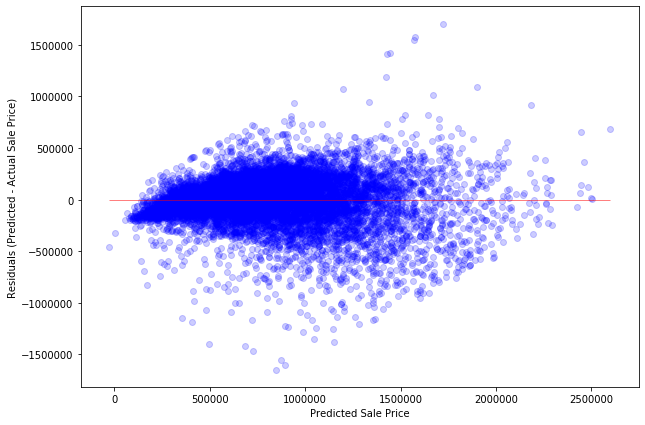

In [150]:
check_lr_assumptions(model_3_stepwise, df_3_final, outcome, predictors)

In [151]:
append_results('model_3_stepwise', formula, model_3_stepwise, df_3_final, outcome, predictors, 
               note='use stepwise selection to pick out 69 features')

Model                                            Formula  \
0              sm_1                          SalePrice ~ SqFtTotLiving   
1              sm_2                          SalePrice ~ SqFtTotLiving   
2          sm_2_log                  log_SalePrice ~ log_SqFtTotLiving   
3         sm_2_sqrt                sqrt_SalePrice ~ sqrt_SqFtTotLiving   
4       sm_2_sqrt_2                     SalePrice ~ sqrt_SqFtTotLiving   
5              sm_3                          SalePrice ~ SqFtTotLiving   
6      model_2_sqrt     SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   
7       model_2_cat          SalePrice ~ SqFtTotLiving + has_OpenPorch   
8      model_3_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Bed...   
9  model_3_stepwise  SalePrice ~ BathFullCount + BldgGrade_10VeryGo...   

   R-Squared  Rainbow statistic  Rainbow p-value Linearity Assumption  \
0   0.386491           0.872905     1.000000e+00            Satisfied   
1   0.399934           1.027984     9.517113e-02            Satisfied   
2   0.291863           1.352501     1.084791e-46             Violated   
3   0.379239           1.053338     6.839964e-03             Violated   
4   0.375599           1.033779     5.747716e-02            Satisfied   
5   0.308273           0.991329     6.565131e-01            Satisfied   
6   0.401072           1.026429     1.079098e-01            Satisfied   
7   0.400308           1.027403     9.979305e-02            Satisfied   
8   0.753468           1.108754     5.300934e-07             Violated   
9   0.750916           1.105696     9.817761e-07             Violated   

   Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0           1.305055e+07         0.000000e+00             Violated   
1           8.752700e+03         0.000000e+00             Violated   
2           3.094762e+06         0.000000e+00             Violated   
3           1.509920e+03         0.000000e+00             Violated   
4           8.842146e+03         0.000000e+00             Violated   
5           1.038380e+03        3.300538e-226             Violated   
6           8.651622e+03         0.000000e+00             Violated   
7           8.742264e+03         0.000000e+00             Violated   
8           3.870986e+04         0.000000e+00             Violated   
9           4.001613e+04         0.000000e+00             Violated   

   Lagrange Multiplier p-value  F-statistic p-value  \
0                          NaN         3.931011e-82   
1                          NaN         0.000000e+00   
2                          NaN         1.163439e-59   
3                          NaN         0.000000e+00   
4                          NaN         0.000000e+00   
5                          NaN         0.000000e+00   
6                          0.0         0.000000e+00   
7                          0.0         0.000000e+00   
8                          0.0         0.000000e+00   
9                          0.0         0.000000e+00   

  Homoskedasticity Assumption  \
0                    Violated   
1                    Violated   
2                    Violated   
3                    Violated   
4                    Violated   
5                    Violated   
6                    Violated   
7                    Violated   
8                    Violated   
9                    Violated   

                                   Multicollinearity Independence Assumption  \
0                                                N/A                     N/A   
1                                                N/A                     N/A   
2                                                N/A                     N/A   
3                                                N/A                     N/A   
4                                                N/A                     N/A   
5                                                N/A                     N/A   
6                                                                  Satisfied   
7             

So, using `stepwise_selection`, I've been able to bring the number of predictors down to 69, while keeping R-Squared above 0.75, which is relatively high (compared to the previous model using all 130 features). 

However, these 2 models both violates all 4 assumptions and will need to be cleaned up further.

In [152]:
model_3_stepwise.params.sort_values(ascending=False)[:30]

DistrictName_YARROWPOINT       1.316813e+06
DistrictName_MEDINA            1.231995e+06
DistrictName_CLYDEHILL         1.144798e+06
DistrictName_BEAUXARTS         9.141379e+05
DistrictName_HUNTSPOINT        8.872589e+05
BldgGrade_12Luxury             6.477984e+05
DistrictName_MERCERISLAND      6.080544e+05
BldgGrade_11Excellent          5.889791e+05
FpAdditional_3                 5.139935e+05
BldgGrade_10VeryGood           4.470574e+05
DistrictName_BELLEVUE          3.945142e+05
DistrictName_KIRKLAND          3.331902e+05
DistrictName_REDMOND           3.106394e+05
DistrictName_SEATTLE           2.878109e+05
BldgGrade_9Better              2.769600e+05
DistrictName_ISSAQUAH          1.770031e+05
Intercept                      1.721985e+05
DistrictName_SAMMAMISH         1.558228e+05
DistrictName_SHORELINE         1.534457e+05
FpSingleStory_4                1.489817e+05
DistrictName_LAKEFORESTPARK    1.418173e+05
BldgGrade_8Good                1.309051e+05
DistrictName_NEWCASTLE         1

In [153]:
# create a function that retrieve features which contain certain keyword in their names
# and their coefficients from a pd Series of params 
def find_features(keyword, params):
    return params[params.index.str.contains(keyword)]

In [154]:
find_features("Heat", model_3_stepwise.params)

HeatSource_Electricity   -42854.637737
HeatSystem_ForcedAir     -23280.988733
HeatSystem_Floor_Wall    -30933.784376
HeatSource_Gas           -14179.792961
dtype: float64

In [179]:
1/np.sqrt(df_3_final.SalePrice)

0        0.001336
1        0.001516
2        0.001242
3        0.001622
4        0.001037
           ...   
18010    0.001129
18011    0.001534
18012    0.001187
18013    0.001552
18014    0.002834
Name: SalePrice, Length: 18015, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


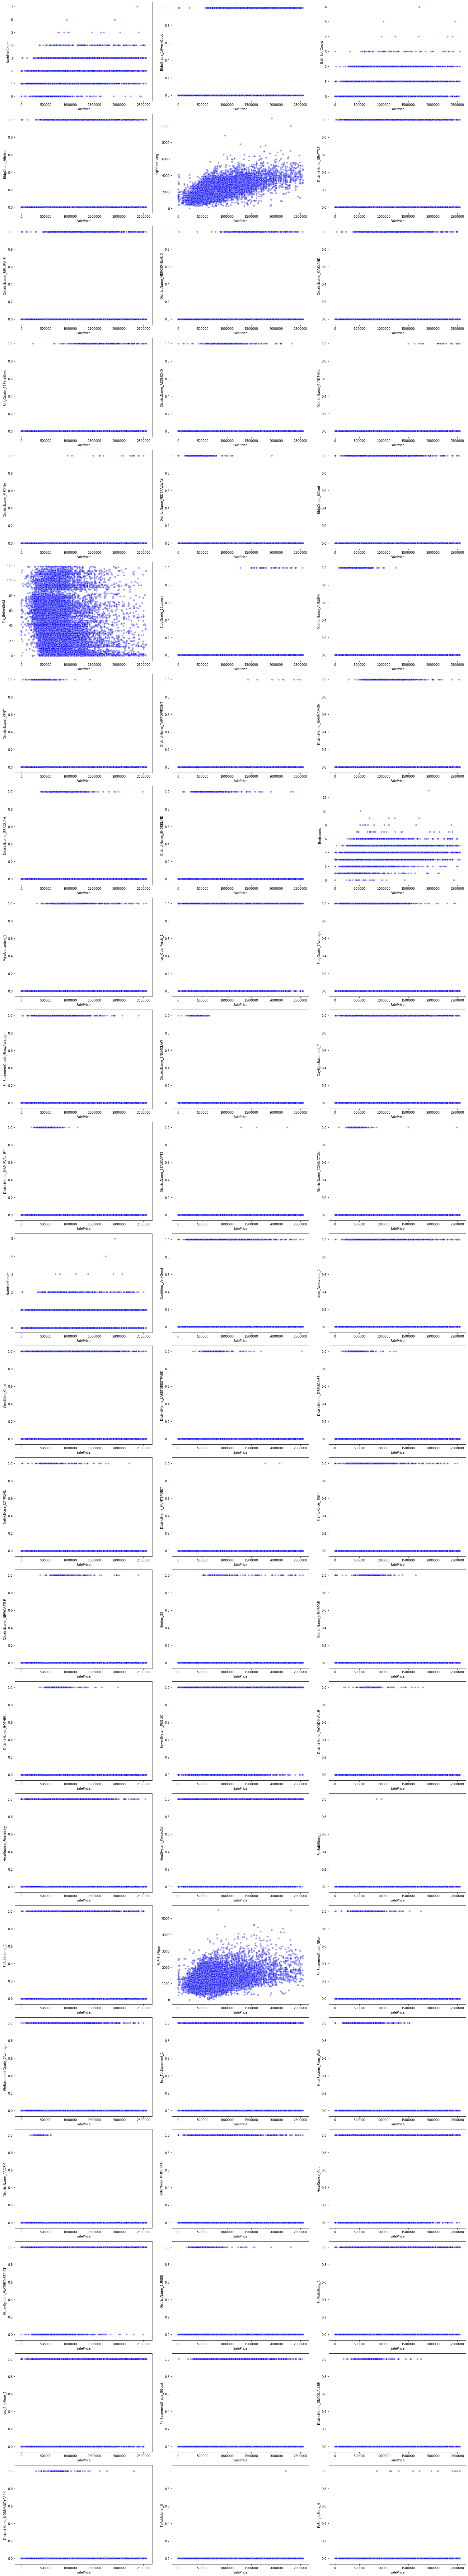

In [155]:
scatterplot_feats_outcome(df_3_final, predictors, 'SalePrice')

In [161]:
find_features("Porch", model_3_stepwise.params)

has_OpenPorch_1    30341.6778
dtype: float64

In [160]:
find_features("Basement", model_3_stepwise.params)

FinBasementGrade_6LowAverage   -71709.269546
DaylightBasement_Y             -39874.326609
FinBasementGrade_5Fair         -69305.803129
FinBasementGrade_7Average      -40557.229901
has_TotBasement_1               23943.679480
FinBasementGrade_8Good         -23395.950488
dtype: float64

In [162]:
find_features("Bedrooms", model_3_stepwise.params)

Bedrooms   -25627.555362
dtype: float64

I still don't understand how the number of Bedrooms could have a negative coefficient????

### Treating some discrete features as categoricals

As mentioned above, I think I'll try to treat some discrete features like `Bedrooms`, `BathHalfCount`, `Bath3qtrCount`, and `BathFullCount` as categoricals instead.

In [165]:
continuous2 = ['SalePrice', 'SqFt1stFloor', 'SqFtTotLiving', 'Yrs_BeforeSold']
df_3_cont2 = df_3[continuous2]

# reset index for df_3_cont for concatenating with df_3_cat later
df_3_cont2.index = range(len(df_3_cont))

In [167]:
# Update the list of categorical features
categoricals2 = ['Stories', 'BldgGrade', 'FinBasementGrade', 'DaylightBasement', 'HeatSystem', 
                 'HeatSource', 'ViewUtilization', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding',
                 'FpAdditional', 'Condition', 'WaterSystem', 'SewerSystem', 'TrafficNoise',
                 'WaterProblems', 'been_Renovated', 'has_HalfFloor', 'has_2ndFloor',
                 'has_TotBasement', 'has_FinBasement', 'has_GarageBasement', 'has_OpenPorch',
                 'has_GarageAttached', 'has_EnclosedPorch', 'has_Deck', 'DistrictName',
                 'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount']

In [168]:
# Apply OneHotEncoder() on categorical predictors
ohe = OneHotEncoder(drop='first')
ohe.fit(df_3[categoricals2])
ohe_trans = ohe.transform(df_3[categoricals2])

# Passing 'categoricals2' into .get_feature_names() will include original feature names 
# in our OHE columns later
column_names = ohe.get_feature_names(categoricals2)

df_3_cat2 = pd.DataFrame(ohe_trans.todense(), columns=column_names)

In [169]:
# concatenate 'df_3_cont' and 'df_3_cat' to create df_4
df_4 = pd.concat([df_3_cont2, df_3_cat2], axis=1)

In [171]:
# Remove identified characters in column names to make sure we don't have problem with
# creating R formula later on

df_4.columns = [x.replace(" ", '')
                 .replace('.', '')
                 .replace("-", "_")
                 .replace("/", "_") for x in df_4.columns]

In [173]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18015 entries, 0 to 18014
Columns: 156 entries, SalePrice to BathFullCount_7
dtypes: float64(152), int64(4)
memory usage: 21.4 MB


Now I have 156 columns including the target variable `SalePrice`. 

In [174]:
# Fitting a model including all 155 predictors
outcome = 'SalePrice'
predictors = get_predictors(df_4, outcome)
formula = create_formula(outcome, predictors)
model_4_full = ols(formula=formula, data=df_4).fit()
model_4_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     360.8
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:37:53   Log-Likelihood:            -2.4492e+05
No. Observations:               18015   AIC:                         4.901e+05
Df Residuals:                   17861   BIC:                         4.913e+05
Df Model:                         153                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       1.41e+06   2.23e+05      6.322      0.000    9.73e+05    1.85e+06
SqFt1stFloor                    -31.4785      7.255     -4.339      0.000     -45.699     -17.258
SqFtTotLiving                   184.5287      4.992     36.968      0.000     174.745     194.313
Yrs_BeforeSold                 1012.4532     98.536     10.275      0.000     819.312    1205.594
Stories_15                     4.827e+05   7.48e+04      6.453      0.000    3.36e+05    6.29e+05
Stories_20                     2.398e+05   1.96e+05      1.222      0.222   -1.45e+05    6.24e+05
Stories_25                     8.214e+05   2.11e+05      3.889      0.000    4.07e+05    1.24e+06
Stories_30                     2.397e+05   1.97e+05      1.219      0.223   -1.46e+05    6.25e+05
Stories_35                     7.702e+05   2.52e+05      3.059      0.002    2.77e+05    1.26e+06
BldgGrade_10VeryGood          -6.485e+05   2.04e+05     -3.175      0.002   -1.05e+06   -2.48e+05
BldgGrade_11Excellent          -5.11e+05   2.05e+05     -2.496      0.013   -9.12e+05    -1.1e+05
BldgGrade_12Luxury            -4.045e+05   2.07e+05     -1.951      0.051   -8.11e+05    1822.166
BldgGrade_13Mansion           -8.641e+05   2.92e+05     -2.964      0.003   -1.44e+06   -2.93e+05
BldgGrade_3Poor               -1.053e+06   2.23e+05     -4.722      0.000   -1.49e+06   -6.16e+05
BldgGrade_4Low                -1.162e+06   2.05e+05     -5.660      0.000   -1.56e+06    -7.6e+05
BldgGrade_5Fair               -1.091e+06   2.04e+05     -5.350      0.000   -1.49e+06   -6.91e+05
BldgGrade_6LowAverage         -1.099e+06   2.04e+05     -5.390      0.000    -1.5e+06   -6.99e+05
BldgGrade_7Average            -1.045e+06   2.04e+05     -5.124      0.000   -1.44e+06   -6.45e+05
BldgGrade_8Good               -9.677e+05   2.04e+05     -4.743      0.000   -1.37e+06   -5.68e+05
BldgGrade_9Better             -8.208e+05   2.04e+05     -4.022      0.000   -1.22e+06   -4.21e+05
FinBasementGrade_10VeryGood    3.624e+04   2.79e+04      1.301      0.193   -1.84e+04    9.08e+04
FinBasementGrade_11Excellent   4.907e+04   3.77e+04      1.301      0.193   -2.49e+04    1.23e+05
FinBasementGrade_12Luxury     -3.467e+05   1.32e+05     -2.619      0.009   -6.06e+05   -8.72e+04
FinBasementGrade_2Substandard   7.31e+04   1.81e+05      0.405      0.686   -2.81e+05    4.27e+05
FinBasementGrade_3Poor         5.314e+04   6.35e+04      0.837      0.403   -7.13e+04    1.78e+05
FinBasementGrade_4Low          1.388e+04   3.88e+04      0.358      0.721   -6.22e+04    8.99e+04
FinBasementGrade_5Fair        -1.071e+04   2.43e+04     -0.441      0.659   -5.83e+04    3.69e+04
FinBasementGrade_6LowAverage  -1.681e+04   2.23e+04     -0.755      0.451   -6.05e+04    2.69e+04
FinBasementGrade_7Average      1.178e+04   2.

					Statistic 	P-value
(Linearity) Rainbow Test 		1.117 		0.0
(Normality) Jarque-Bera Test 		37623.866 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)



Independence:
             feature          VIF
0       SqFt1stFloor    44.965032
1      SqFtTotLiving    61.729372
2     Yrs_BeforeSold    13.350567
3         Stories_15   217.127112
4         Stories_20  7480.829227
..               ...          ...
150  BathFullCount_3    10.255693
151  BathFullCount_4     2.219635
152  BathFullCount_5     1.298428
153  BathFullCount_6     2.030020
154  BathFullCount_7     1.139051

[155 rows x 2 columns]


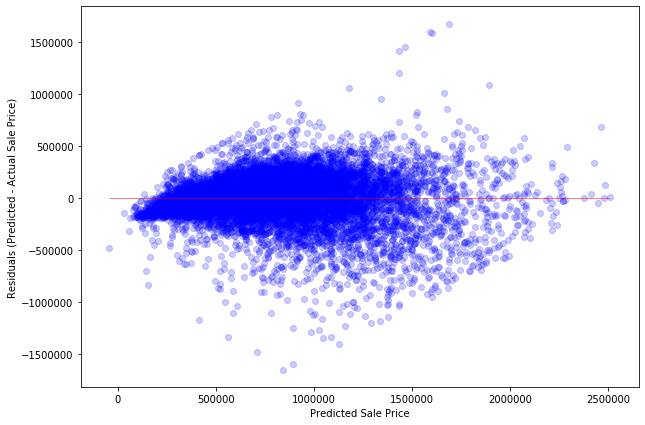

In [175]:
check_lr_assumptions(model_4_full, df_4, outcome, predictors)

In [176]:
append_results('model_4_full', formula, model_4_full, df_4, outcome, predictors, 
               note='treat discrete vars as categoricals, fit model on 155 predictors')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Model                                            Formula  \
0               sm_1                          SalePrice ~ SqFtTotLiving   
1               sm_2                          SalePrice ~ SqFtTotLiving   
2           sm_2_log                  log_SalePrice ~ log_SqFtTotLiving   
3          sm_2_sqrt                sqrt_SalePrice ~ sqrt_SqFtTotLiving   
4        sm_2_sqrt_2                     SalePrice ~ sqrt_SqFtTotLiving   
5               sm_3                          SalePrice ~ SqFtTotLiving   
6       model_2_sqrt     SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   
7        model_2_cat          SalePrice ~ SqFtTotLiving + has_OpenPorch   
8       model_3_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Bed...   
9   model_3_stepwise  SalePrice ~ BathFullCount + BldgGrade_10VeryGo...   
10      model_4_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Yrs...   

    R-Squared  Rainbow statistic  Rainbow p-value Linearity Assumption  \
0    0.386491           0.872905     1.000000e+00            Satisfied   
1    0.399934           1.027984     9.517113e-02            Satisfied   
2    0.291863           1.352501     1.084791e-46             Violated   
3    0.379239           1.053338     6.839964e-03             Violated   
4    0.375599           1.033779     5.747716e-02            Satisfied   
5    0.308273           0.991329     6.565131e-01            Satisfied   
6    0.401072           1.026429     1.079098e-01            Satisfied   
7    0.400308           1.027403     9.979305e-02            Satisfied   
8    0.753468           1.108754     5.300934e-07             Violated   
9    0.750916           1.105696     9.817761e-07             Violated   
10   0.755556           1.116563     9.528427e-08             Violated   

    Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0            1.305055e+07         0.000000e+00             Violated   
1            8.752700e+03         0.000000e+00             Violated   
2            3.094762e+06         0.000000e+00             Violated   
3            1.509920e+03         0.000000e+00             Violated   
4            8.842146e+03         0.000000e+00             Violated   
5            1.038380e+03        3.300538e-226             Violated   
6            8.651622e+03         0.000000e+00             Violated   
7            8.742264e+03         0.000000e+00             Violated   
8            3.870986e+04         0.000000e+00             Violated   
9            4.001613e+04         0.000000e+00             Violated   
10           3.762387e+04         0.000000e+00             Violated   

    Lagrange Multiplier p-value  F-statistic p-value  \
0                           NaN         3.931011e-82   
1                           NaN         0.000000e+00   
2                           NaN         1.163439e-59   
3                           NaN         0.000000e+00   
4                           NaN         0.000000e+00   
5                           NaN         0.000000e+00   
6                           0.0         0.000000e+00   
7                           0.0         0.000000e+00   
8                           0.0         0.000000e+00   
9                           0.0         0.000000e+00   
10                          0.0         0.000000e+00   

   Homoskedasticity Assumption  \
0                     Violated   
1                     Violated   
2                     Violated   
3                     Violated   
4                     Violated   
5                     Violated   
6                     Violated   
7                     Violated   
8                     Violated   
9                     Violated   
10                    Violated   

                                    Multicollinearity Independence Assumption  \
0                                                 N/A                     N/A   
1                                                 N/A                     N/A   
2                                              

In [192]:
len(model_results.loc[9].Multicollinearity.split(','))

13

In [187]:
model_results.loc[10].Multicollinearity

'SqFt1stFloor, SqFtTotLiving, Yrs_BeforeSold, Stories_15, Stories_20, Stories_25, Stories_30, BldgGrade_10VeryGood, BldgGrade_11Excellent, BldgGrade_12Luxury, BldgGrade_4Low, BldgGrade_5Fair, BldgGrade_6LowAverage, BldgGrade_7Average, BldgGrade_8Good, BldgGrade_9Better, FinBasementGrade_10VeryGood, FinBasementGrade_11Excellent, FinBasementGrade_12Luxury, FinBasementGrade_2Substandard, FinBasementGrade_3Poor, FinBasementGrade_4Low, FinBasementGrade_5Fair, FinBasementGrade_6LowAverage, FinBasementGrade_7Average, FinBasementGrade_8Good, FinBasementGrade_9Better, HeatSystem_ElecBB, HeatSystem_Floor_Wall, HeatSystem_ForcedAir, HeatSystem_Gravity, HeatSystem_HeatPump, HeatSystem_HotWater, HeatSystem_Other, HeatSystem_Radiant, HeatSource_Electricity, HeatSource_Electricity_Solar, HeatSource_Gas, HeatSource_Gas_Solar, HeatSource_Oil, HeatSource_Other, WaterSystem_PRIVATE, WaterSystem_WATERDISTRICT, SewerSystem_PRIVATE, SewerSystem_PUBLIC, has_HalfFloor_1, has_2ndFloor_1, has_TotBasement_1, has

And now I'm going to use `stepwise_selection()` on this version of the dataset `df_4` to see what it picks out. 

In [180]:
X4 = df_4.drop('SalePrice', axis=1)
y4 = df_4.SalePrice

In [181]:
predictors = stepwise_selection(X4, y4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  SqFt1stFloor                   with p-value 0.0
Add  Stories_20                     with p-value 0.0
Add  has_FinBasement_1              with p-value 0.0
Add  SqFtTotLiving                  with p-value 0.0
Add  DistrictName_SEATTLE           with p-value 0.0
Drop Stories_20                     with p-value 0.503083
Add  DistrictName_BELLEVUE          with p-value 0.0
Add  DistrictName_MERCERISLAND      with p-value 8.16613e-274
Add  DistrictName_KIRKLAND          with p-value 5.4048e-267
Add  BldgGrade_10VeryGood           with p-value 9.16105e-153
Add  BldgGrade_9Better              with p-value 1.7249e-158
Add  BldgGrade_11Excellent          with p-value 9.97188e-175
Add  DistrictName_REDMOND           with p-value 7.29792e-149
Add  DistrictName_CLYDEHILL         with p-value 2.11023e-114
Add  DistrictName_MEDINA            with p-value 4.55339e-107
Add  DistrictName_FEDERALWAY        with p-value 1.36917e-78
Add  BldgGrade_8Good                with p-value 2.77348e-81
Add  Yrs

In [182]:
len(predictors)

77

In [183]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors)
model_4_stepwise = ols(formula=formula, data=df_4).fit()
model_4_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     706.9
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:56:52   Log-Likelihood:            -2.4504e+05
No. Observations:               18015   AIC:                         4.902e+05
Df Residuals:                   17937   BIC:                         4.908e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.405e+05   1.49e+04      9.412      0.000    1.11e+05     1.7e+05
has_FinBasement_1            -4.238e+04   7069.221     -5.995      0.000   -5.62e+04   -2.85e+04
SqFtTotLiving                  181.0960      4.457     40.627      0.000     172.359     189.833
DistrictName_SEATTLE          2.909e+05   5548.449     52.423      0.000     2.8e+05    3.02e+05
DistrictName_BELLEVUE         3.931e+05   7914.279     49.671      0.000    3.78e+05    4.09e+05
DistrictName_MERCERISLAND     6.089e+05   1.47e+04     41.479      0.000     5.8e+05    6.38e+05
DistrictName_KIRKLAND         3.341e+05   7991.231     41.814      0.000    3.18e+05     3.5e+05
BldgGrade_10VeryGood          4.632e+05   1.14e+04     40.707      0.000    4.41e+05    4.85e+05
BldgGrade_9Better             2.882e+05   8838.896     32.607      0.000    2.71e+05    3.06e+05
BldgGrade_11Excellent         6.038e+05   1.69e+04     35.785      0.000    5.71e+05    6.37e+05
DistrictName_REDMOND          3.103e+05   1.06e+04     29.147      0.000    2.89e+05    3.31e+05
DistrictName_CLYDEHILL        1.148e+06   4.23e+04     27.164      0.000    1.06e+06    1.23e+06
DistrictName_MEDINA            1.24e+06   4.93e+04     25.164      0.000    1.14e+06    1.34e+06
DistrictName_FEDERALWAY      -1.518e+05   7892.277    -19.235      0.000   -1.67e+05   -1.36e+05
BldgGrade_8Good                1.37e+05   7146.720     19.163      0.000    1.23e+05    1.51e+05
Yrs_BeforeSold                 919.5976     89.666     10.256      0.000     743.843    1095.352
BldgGrade_12Luxury            6.929e+05   3.22e+04     21.496      0.000     6.3e+05    7.56e+05
DistrictName_AUBURN          -1.487e+05   8586.021    -17.323      0.000   -1.66e+05   -1.32e+05
DistrictName_KENT            -1.025e+05   7712.273    -13.294      0.000   -1.18e+05   -8.74e+04
DistrictName_YARROWPOINT      1.319e+06   6.55e+04     20.124      0.000    1.19e+06    1.45e+06
DistrictName_SAMMAMISH        1.543e+05   8599.475     17.945      0.000    1.37e+05    1.71e+05
DistrictName_ISSAQUAH         1.804e+05   1.22e+04     14.807      0.000    1.57e+05    2.04e+05
DistrictName_SHORELINE        1.562e+05   9737.174     16.045      0.000    1.37e+05    1.75e+05
ViewUtilization_Y             1.074e+05   1.07e+04     10.000      0.000    8.64e+04    1.28e+05
been_Renovated_1              6.849e+04   7628.090      8.978      0.000    5.35e+04    8.34e+04
Condition_VeryGood            5.359e+04   5381.297      9.958      0.000     4.3e+04    6.41e+04
has_OpenPorch_1               3.075e+04   3282.693      9.366      0.000    2.43e+04    3.72e+04
DistrictName_ENUMCLAW        -1.235e+05   1.41e+04     -8.743      0.000   -1.51e+05   -9.58e+04
Condition_Good                3.044e+04   3827.014      7.953      0.000    

					Statistic 	P-value
(Linearity) Rainbow Test 		1.112 		0.0
(Normality) Jarque-Bera Test 		39886.522 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	0.0 				0.0

Independence:
                      feature        VIF
0           has_FinBasement_1   9.321803
1               SqFtTotLiving  48.033323
2        DistrictName_SEATTLE   4.267294
3       DistrictName_BELLEVUE   1.435025
4   DistrictName_MERCERISLAND   1.143443
..                        ...        ...
72            FpSingleStory_2   1.213809
73    DistrictName_SNOQUALMIE   1.095434
74             FpAdditional_3   1.008047
75            FpSingleStory_4   1.025512
76             FpMultiStory_1   2.456278

[77 rows x 2 columns]


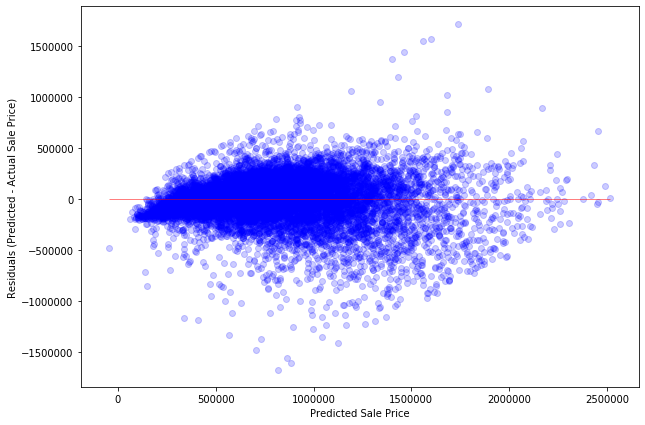

In [184]:
check_lr_assumptions(model_4_stepwise, df_4, outcome, predictors)

In [188]:
append_results('model_4_stepwise', formula, model_4_stepwise, df_4, outcome, predictors, 
               note='stepwise selection, 77 predictors')

Model                                            Formula  \
0               sm_1                          SalePrice ~ SqFtTotLiving   
1               sm_2                          SalePrice ~ SqFtTotLiving   
2           sm_2_log                  log_SalePrice ~ log_SqFtTotLiving   
3          sm_2_sqrt                sqrt_SalePrice ~ sqrt_SqFtTotLiving   
4        sm_2_sqrt_2                     SalePrice ~ sqrt_SqFtTotLiving   
5               sm_3                          SalePrice ~ SqFtTotLiving   
6       model_2_sqrt     SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch   
7        model_2_cat          SalePrice ~ SqFtTotLiving + has_OpenPorch   
8       model_3_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Bed...   
9   model_3_stepwise  SalePrice ~ BathFullCount + BldgGrade_10VeryGo...   
10      model_4_full  SalePrice ~ SqFt1stFloor + SqFtTotLiving + Yrs...   
11  model_4_stepwise  SalePrice ~ has_FinBasement_1 + SqFtTotLiving ...   

    R-Squared  Rainbow statistic  Rainbow p-value Linearity Assumption  \
0    0.386491           0.872905     1.000000e+00            Satisfied   
1    0.399934           1.027984     9.517113e-02            Satisfied   
2    0.291863           1.352501     1.084791e-46             Violated   
3    0.379239           1.053338     6.839964e-03             Violated   
4    0.375599           1.033779     5.747716e-02            Satisfied   
5    0.308273           0.991329     6.565131e-01            Satisfied   
6    0.401072           1.026429     1.079098e-01            Satisfied   
7    0.400308           1.027403     9.979305e-02            Satisfied   
8    0.753468           1.108754     5.300934e-07             Violated   
9    0.750916           1.105696     9.817761e-07             Violated   
10   0.755556           1.116563     9.528427e-08             Violated   
11   0.752139           1.112416     2.295015e-07             Violated   

    Jarque-Bera statistic  Jarque-Bera p-value Normality Assumption  \
0            1.305055e+07         0.000000e+00             Violated   
1            8.752700e+03         0.000000e+00             Violated   
2            3.094762e+06         0.000000e+00             Violated   
3            1.509920e+03         0.000000e+00             Violated   
4            8.842146e+03         0.000000e+00             Violated   
5            1.038380e+03        3.300538e-226             Violated   
6            8.651622e+03         0.000000e+00             Violated   
7            8.742264e+03         0.000000e+00             Violated   
8            3.870986e+04         0.000000e+00             Violated   
9            4.001613e+04         0.000000e+00             Violated   
10           3.762387e+04         0.000000e+00             Violated   
11           3.988652e+04         0.000000e+00             Violated   

    Lagrange Multiplier p-value  F-statistic p-value  \
0                           NaN         3.931011e-82   
1                           NaN         0.000000e+00   
2                           NaN         1.163439e-59   
3                           NaN         0.000000e+00   
4                           NaN         0.000000e+00   
5                           NaN         0.000000e+00   
6                           0.0         0.000000e+00   
7                           0.0         0.000000e+00   
8                           0.0         0.000000e+00   
9                           0.0         0.000000e+00   
10                          0.0         0.000000e+00   
11                          0.0         0.000000e+00   

   Homoskedasticity Assumption  \
0                     Violated   
1                     Violated   
2                     Violated   
3                     Violated   
4                     Violated   
5                     Violated   
6                     Violated   
7                     Violated   
8                     Violated   
9                     Violated   
10                    Violated   
11             

In [191]:
len(model_results.loc[11].Multicollinearity.split(','))

11

R-Squared for `model_4_stepwise` is higher than `model_3_stepwise`. Also, Rainbow p-value seems to go down a little bit from 9.817761e-07 to 2.295015e-07.

Although, on the bright side of things, `model_4_stepwise` has 11 variables with VIF > 5, which is less than what `model_3_stepwise` has (13).

Really need to figure out how to improve these scores and meet at least 1 assumption.

So far, I haven't really paid too much attention to the Residuals plots (aside from whether or not they look homoskedatic) --> probably need to figure out how to diagnose problems using residual plots.